In [24]:
import os 
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import requests
import cv2 
from numpy.polynomial import Polynomial
from skimage.morphology import skeletonize, binary_closing, square, binary_erosion, binary_dilation, medial_axis, thin, disk, convex_hull_image, diamond, star, isotropic_closing, remove_small_objects
from skimage.filters import threshold_otsu
import json

In [25]:
sem_segm_img_path = "/Users/senneloobuyck/Documents/Thesis_project/04_matching/2023_RVV_1_mask_51.jpg"
mapbox_imgs_dir_path = "/Users/senneloobuyck/Documents/Thesis_project/04_matching/mapbox_images_for_frame_51_RVV1"
heli_lat = 50.77718166666666
heli_lon = 3.52441
# 2 intersections so 2 solutions possible
intersec_lat1 = 50.7786715
intersec_lon1 = 3.5252944
intersec_lat2 = 50.7788689
intersec_lon2 = 3.5254466
altitude = 158.12

In [26]:
def plot_image(img):
    plt.figure(figsize=(20,10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [27]:
def calculate_bearing(lat1, long1, lat2, long2) : 
    lat1 = math.radians(lat1)
    long1 = math.radians(long1)
    lat2 = math.radians(lat2)
    long2 = math.radians(long2)

    d_long = long2 - long1

    y = math.sin(d_long) * math.cos(lat2)
    x = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(d_long)

    brng = math.atan2(y, x)

    brng = math.degrees(brng)
    brng = (brng + 360) % 360
    # brng = 360 - brng # count degrees clockwise - remove to make counter-clockwise
    return brng

In [28]:
def haversine(lat1, lon1, lat2, lon2) : 
    R = 6371
    d_lat = math.radians(lat2 - lat1)
    d_lon = math.radians(lon2 - lon1)
    lat1 = math.radians(lat1)
    lat2 = math.radians(lat2)
    a = math.sin(d_lat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(d_lon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = R * c * 1000
    return d

In [29]:
# calculate pitch/tilt
def calculate_pitch(heli_lat, heli_lon, intersec_lat, intersec_lon, heli_df) : 
    dist = haversine(heli_lat, heli_lon, intersec_lat, intersec_lon)

    result = heli_df[(heli_df['lat'] == heli_lat) & (heli_df['lng'] == heli_lon)]
    if not result.empty:
        altitude = result.iloc[0]['alt']

    print(f"Distance: {dist}")
    print(f"Altitude: {altitude}")

    alpha_radian = math.atan2(altitude, dist)
    alpha_degrees = alpha_radian * (180.0 / math.pi)
    pitch = 90 - alpha_degrees
    return pitch 

In [30]:
def get_mapbox_intersection_image(lat, lon, bearing, tilt) : 
    if tilt > 60 :
        tilt = 60
    zoom = 18
    width = 512
    height = 512
    access_token = "pk.eyJ1Ijoic2VubmVsb29idXljayIsImEiOiJjbG1zeDVreHowZmw5Mm1xY2lxeTFtYTB2In0.ymj-xZAfeeivbksi1PJttw" 
    styles_url = "mapbox://styles/senneloobuyck/cllcojw8d00wy01pb6rqcdmm5"

    style_code = styles_url.split('/')[-1]

    url = f"https://api.mapbox.com/styles/v1/senneloobuyck/{style_code}/static/{str(lon)},{str(lat)},{str(zoom)},{str(bearing)},{str(tilt)}/{str(width)}x{str(height)}?access_token={access_token}"

    response = requests.get(url)

    if response.status_code == 200:
        with open(f"{lat}_{lon}.png", "wb") as f:
            f.write(response.content)
        print(f"Image saved as {lat}_{lon}.png")
    else:
        print("Failed to retrieve image for intersection lat = " + str(lat) + ", lon = " + str(lon))
        print(response.text[:100])

In [31]:
def get_intersection_coordinates(lat, lon) : 
    # some lists and dataframes to store the data
    nodes = []
    intersection_nodes = []
    df_nodes = pd.DataFrame(columns=['id', 'lat', 'lon'])
    df_intersections = pd.DataFrame(columns=['lat', 'lon'])

    overpass_url = "http://overpass-api.de/api/interpreter"


    # first get the ways around the point 
    # .w is a temporary variable that stores the result of the first query
    # node(way_cnt:2-);   // select those nodes that are members of two or more of the given ways
    overpass_query = f"""[out:json];
                        way(around: 300, {lat},{lon})["highway"]->.w;
                        node(way_cnt.w:2-);  
                        out;"""

    response = requests.get(overpass_url, params={'data': overpass_query})

    for item in response.json()['elements']:
        df_intersections.loc[len(df_intersections)] = {'lat': item['lat'], 'lon': item['lon']}


    # print(df_intersections)
    return df_intersections

In [32]:
df_intersections = get_intersection_coordinates(heli_lat, heli_lon)

# read in csv file with heli coordinates
heli_path = "/Users/senneloobuyck/Documents/Thesis_project/01_inputs/csv-files/2023 Ronde van Vlaanderen 1 heli.csv"
heli_df = pd.read_csv(heli_path)
heli_df['lat'] = heli_df.apply(lambda row: float(row['lat']) * 1 if row['NS'] == 'N' else float(row['lat']) * (-1), axis=1)
heli_df['lng'] = heli_df.apply(lambda row: float(row['lng']) * 1 if row['EW'] == 'E' else float(row['lng']) * (-1), axis=1)
heli_df = heli_df[['lat', 'lng', 'alt', 'seconds_from_start']]

for index, row in df_intersections.iterrows() : 
    print(f"Intersection: {row['lat']},{row['lon']}")
    bearing = calculate_bearing(heli_lat, heli_lon, row['lat'], row['lon'])
    print(f"Bearing = {bearing}")
    pitch = calculate_pitch(heli_lat, heli_lon, row['lat'], row['lon'], heli_df)
    print(f"Pitch = {pitch}")
    # get_mapbox_intersection_image(row['lat'], row['lon'], bearing, pitch)

Intersection: 50.777904,3.5203477
Bearing = 285.70771136286885
Distance: 296.70757947325524
Altitude: 158.12
Pitch = 61.946165010518186
Intersection: 50.7788689,3.5254466
Bearing = 21.2301410999591
Distance: 201.27193206204785
Altitude: 158.12
Pitch = 51.84668672574508
Intersection: 50.7773096,3.5252422
Bearing = 76.3354399287017
Distance: 60.218583283079326
Altitude: 158.12
Pitch = 20.848886319972536
Intersection: 50.7771783,3.520804
Bearing = 269.916801224573
Distance: 253.54811233475522
Altitude: 158.12
Pitch = 58.05113160226221
Intersection: 50.7777499,3.5224676
Bearing = 294.82781575906085
Distance: 150.48237698060254
Altitude: 158.12
Pitch = 43.58227193473123
Intersection: 50.7786715,3.5252944
Bearing = 20.574015630418444
Distance: 176.94821325677256
Altitude: 158.12
Pitch = 48.21619247699139
Intersection: 50.7756171,3.5245493
Bearing = 176.7775575642264
Distance: 174.24738252542892
Altitude: 158.12
Pitch = 47.777970484413004
Intersection: 50.7749412,3.5228001
Bearing = 204.43676

In [33]:
def get_skeleton(mask_bgr, contour) : 
    # print("Getting the skeleton and the pruned skeleton")

    mask_gray = cv2.cvtColor(mask_bgr, cv2.COLOR_BGR2GRAY)

    # draw contour in white on black background
    contour_mask_gray = np.zeros_like(mask_gray)
    cv2.drawContours(contour_mask_gray, [contour], -1, 255, -1)
    contour_mask_bgr = cv2.cvtColor(contour_mask_gray, cv2.COLOR_GRAY2BGR)
    
    # To avoid the precision loss when converting the image to bool, 
    # you can also binarize the image using one of the available thresholding algorithms
    thresh = threshold_otsu(contour_mask_gray)
    contour_mask_gray = contour_mask_gray > thresh
    
    # 1. Skeletonize
    # skeleton_gray = (skeletonize(contour_mask_gray)).astype(np.uint8)
    skeleton_gray = skeletonize(contour_mask_gray, method='lee').astype(np.uint8)

    np.set_printoptions(threshold=np.inf)
    # print("Skeleton image values:")
    # print(skeleton_gray)


    # plt.figure(figsize=(20,10))
    # plt.imshow(skeleton_gray, cmap='gray', interpolation='nearest')
    # plt.show()

    skeleton_bgr = cv2.cvtColor(skeleton_gray, cv2.COLOR_GRAY2BGR)

    return skeleton_bgr
            

In [34]:
def get_skeleton_intersection(skeleton):
    """ Given a skeletonised image, it will give the coordinates of the intersections of the skeleton"""
    print("Getting intersections in skeleton (more than 2 neighbours)")
    # A list of valid intersections             
    # These are in the format (clockwise order)
    # 2 3 4
    # 1 C 5
    # 8 7 6 
    validIntersection = [[0,1,0,1,0,0,1,0],[0,0,1,0,1,0,0,1],[1,0,0,1,0,1,0,0],
                         [0,1,0,0,1,0,1,0],[0,0,1,0,0,1,0,1],[1,0,0,1,0,0,1,0],
                         [0,1,0,0,1,0,0,1],[1,0,1,0,0,1,0,0],[0,1,0,0,0,1,0,1],
                         [0,1,0,1,0,0,0,1],[0,1,0,1,0,1,0,0],[0,0,0,1,0,1,0,1],
                         [1,0,1,0,0,0,1,0],[1,0,1,0,1,0,0,0],[0,0,1,0,1,0,1,0],
                         [1,0,0,0,1,0,1,0],[1,0,0,1,1,1,0,0],[0,0,1,0,0,1,1,1],
                         [1,1,0,0,1,0,0,1],[0,1,1,1,0,0,1,0],[1,0,1,1,0,0,1,0],
                         [1,0,1,0,0,1,1,0],[1,0,1,1,0,1,1,0],[0,1,1,0,1,0,1,1],
                         [1,1,0,1,1,0,1,0],[1,1,0,0,1,0,1,0],[0,1,1,0,1,0,1,0],
                         [0,0,1,0,1,0,1,1],[1,0,0,1,1,0,1,0],[1,0,1,0,1,1,0,1],
                         [1,0,1,0,1,1,0,0],[1,0,1,0,1,0,0,1],[0,1,0,0,1,0,1,1],
                         [0,1,1,0,1,0,0,1],[1,1,0,1,0,0,1,0],[0,1,0,1,1,0,1,0],
                         [0,0,1,0,1,1,0,1],[1,0,1,0,0,1,0,1],[1,0,0,1,0,1,1,0],
                         [1,0,1,1,0,1,0,0]]
    skeleton_gray = cv2.cvtColor(skeleton, cv2.COLOR_BGR2GRAY)
    image = skeleton_gray.copy()
    image = image/255
    intersections = []
    for x in range(1,len(image)-1):
        for y in range(1,len(image[x])-1):
            # if we have a white pixel
            if image[x][y] == 1:
                neighbours = [image[x-1][y], image[x-1][y-1], image[x][y-1], image[x+1][y-1], image[x+1][y], image[x+1][y+1], image[x][y+1], image[x-1][y+1]]
                if neighbours in validIntersection:
                    intersections.append((y,x))
    # Filter intersections to make sure we don't count them twice or ones that are very close together
    # for point1 in intersections:
    #     for point2 in intersections:
    #         if (((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2) < 10**2) and (point1 != point2):
    #             intersections.remove(point2)
    # Remove duplicates
    return intersections


In [35]:
def prune_skeleton(skeleton_contour_bgr, skel_intersections, threshold) : 
    print("Pruning the skeleton")
    pruned_skeleton_contour_bgr = np.zeros_like(skeleton_contour_bgr) 
    bad_contours = []
    for intersection in skel_intersections : 
        pruned_skeleton_contour_bgr_help = skeleton_contour_bgr.copy()
        # cv2.circle(pruned_skeleton_contour_bgr_help, (intersection[0], intersection[1]), 1, (0,0,0), -1)
        pruned_skeleton_contour_bgr_help[intersection[1], intersection[0]] = (0,0,0)

        pruned_skeleton_contour_gray_help = cv2.cvtColor(pruned_skeleton_contour_bgr_help, cv2.COLOR_BGR2GRAY)
        contours, hierarchy = cv2.findContours(pruned_skeleton_contour_gray_help, cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours : 
            if cv2.arcLength(contour, closed=False) > threshold :
                cv2.drawContours(pruned_skeleton_contour_bgr, [contour], contourIdx=-1, color=(255, 255, 255), thickness=1)
            else : 
                bad_contours.append(contour)

    for bad_contour in bad_contours :
        cv2.drawContours(pruned_skeleton_contour_bgr, [bad_contour], contourIdx=-1, color=(0, 0, 0), thickness=1)

    for intersection in skel_intersections : 
        pruned_skeleton_contour_bgr[intersection[1], intersection[0]] = (255,255,255)
    return pruned_skeleton_contour_bgr    

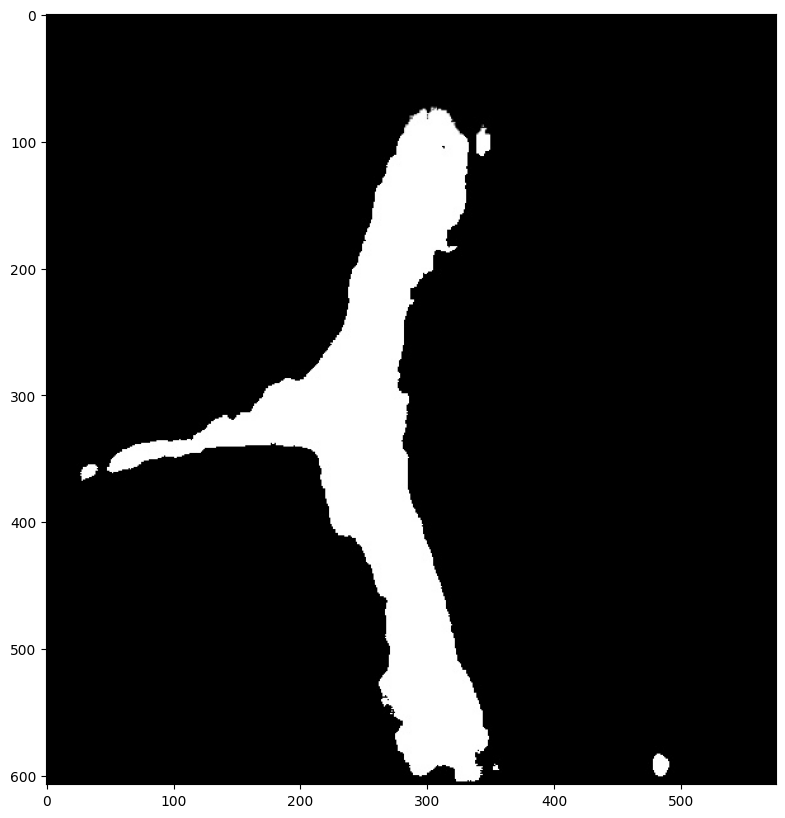

In [36]:
img_bgr = cv2.imread(sem_segm_img_path)
plot_image(img_bgr)

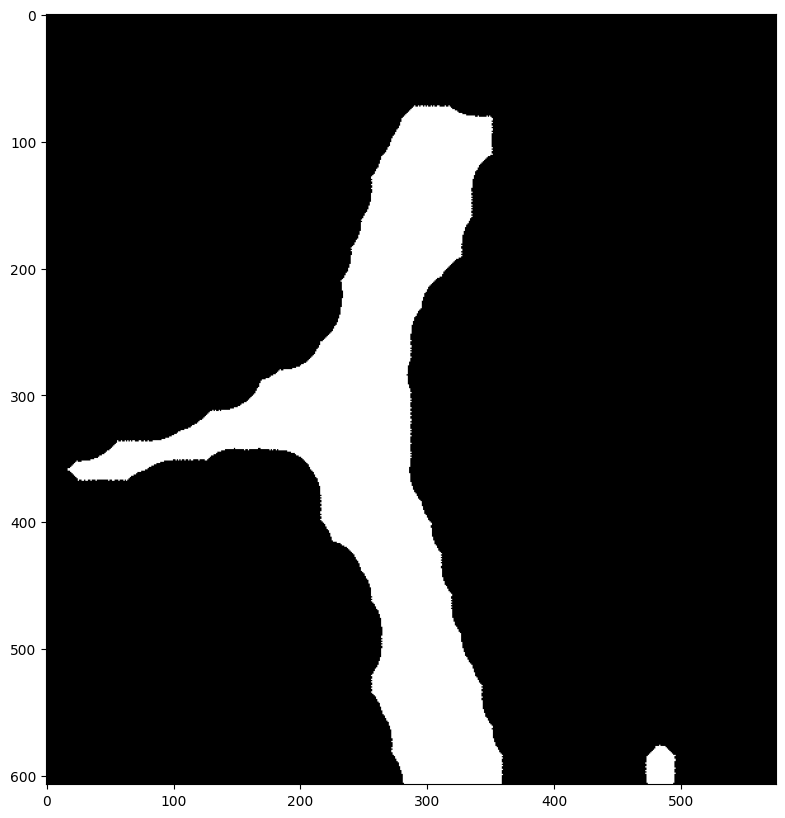

Shape of closing_bgr: (607, 575, 3)


In [37]:
closing_bgr = isotropic_closing(img_bgr, radius=30)
closing_bgr = closing_bgr.astype(np.uint8) * 255
plot_image(closing_bgr)
print(f"Shape of closing_bgr: {closing_bgr.shape}")

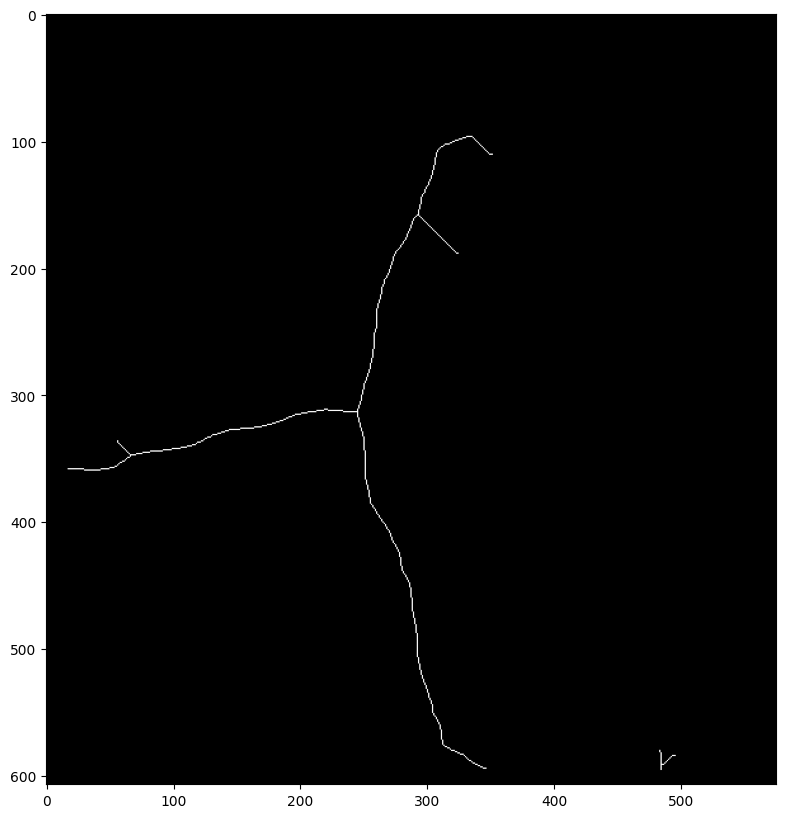

In [38]:
mask_bgr = closing_bgr.copy()
mask_bgr_copy = mask_bgr.copy()
mask_gray = cv2.cvtColor(mask_bgr, cv2.COLOR_BGR2GRAY)
mask_gray_copy = mask_gray.copy()
skeleton_gray = skeletonize(mask_gray)
skeleton_gray = skeleton_gray.astype(np.uint8) * 255
skeleton_bgr = cv2.cvtColor(skeleton_gray, cv2.COLOR_GRAY2BGR)
plot_image(skeleton_bgr)

In [39]:
def get_patch_from_intersection(skel_contour_bgr, intersec, patch_size) : 
    # print("Getting patch from intersection")
    skel_contour_gray = cv2.cvtColor(skel_contour_bgr, cv2.COLOR_BGR2GRAY)

    # Calculate the coordinates of the patch boundaries
    x, y = intersec[0], intersec[1]
    x_min, x_max = x - patch_size // 2, x + patch_size // 2 + 1
    y_min, y_max = y - patch_size // 2, y + patch_size // 2 + 1

    # Ensure the coordinates are within the image bounds
    x_min = max(0, x_min)
    x_max = min(skel_contour_gray.shape[1], x_max)
    y_min = max(0, y_min)
    y_max = min(skel_contour_gray.shape[0], y_max)

    # Extract the patch
    patch = skel_contour_gray[y_min:y_max, x_min:x_max]

    # Patch intersection value
    patch_intersection = (patch.shape[0]//2, patch.shape[1]//2)

    # Calculate neighbour pixels that define the roads that intersect (in patch values)
    road_neighbour_pixels = []
    for x in range(-1,2):
        for y in range(-1,2):
            if patch[patch_intersection[1]+y, patch_intersection[0]+x] == 255 and (x != 0 or y != 0):
                road_neighbour_pixels.append((patch_intersection[0]+x, patch_intersection[1]+y))

    return patch, road_neighbour_pixels

In [40]:
def find_road_pixels(patch, reference_pixel, neighbour_pixels, intersection, visited_pixels=None):
    if visited_pixels is None:
        visited_pixels = set()

    # print("Finding road pixels")
    # print(f"Intersection = {intersection}")
    patch_size = patch.shape[0]
    road_pixels = []

    for x in range(-1, 2):
        for y in range(-1, 2):
            pixel = (reference_pixel[0] + x, reference_pixel[1] + y)

            # Check if the pixel has been visited or is out of bounds
            if pixel[0] < 0 or pixel[0] >= patch_size or pixel[1] < 0 or pixel[1] >= patch_size or pixel in visited_pixels:
                continue

            # Check if the pixel is a road pixel and not the intersection itself
            if patch[pixel[1], pixel[0]] == 255 and (x != 0 or y != 0) and pixel != intersection and pixel not in neighbour_pixels:
                road_pixels.append(pixel)
                visited_pixels.add(pixel)
                # Recursively search from this pixel
                road_pixels += find_road_pixels(patch, pixel, neighbour_pixels, intersection, visited_pixels)
    
    return road_pixels


In [41]:
def get_descriptor(patch, neighbour_pixels) : 
    # For visualisation purposes
    patch_bgr = cv2.cvtColor(patch, cv2.COLOR_GRAY2BGR)
    
    # Find intersection and set value to 0
    intersection = (patch.shape[0]//2, patch.shape[1]//2)
    patch[intersection[0], intersection[1]] = 0

    angles_vector = []
    
    
    
    # if lines is None : 
    #     print("No houghlines found")
    # else :
    #     for i in range(0, len(lines)):
    #         rho = lines[i][0][0]
    #         theta = lines[i][0][1]
    #         a = math.cos(theta)
    #         b = math.sin(theta)
    #         x0 = a * rho
    #         y0 = b * rho
    #         pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    #         pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    #         cv2.line(patch_bgr, pt1, pt2, (0, 0, 255), 3, cv2.LINE_AA)

    # print("Patch with houghlines")
    # plot_image(patch_bgr)

    for neighbour_pixel in neighbour_pixels :
        road_pixels = find_road_pixels(patch, neighbour_pixel, neighbour_pixels, intersection, None)
        road_pixels.append(neighbour_pixel)
        road_pixels.append(intersection)
        print(f"Road pixels for neighbour pixel {neighbour_pixel} (including intersection): ")
        # print(road_pixels)

        # now append the neighbour pixel AND the intersection pixel to the road pixels 
        # road_pixels.append(intersection)

        # Switch y values because the y axis is inverted
        road_pixels = [(pixel[0], (patch.shape[0]-1) - pixel[1]) for pixel in road_pixels]

        # Adjust the coordinates of road pixels and intersection to be relative to the center
        adjusted_road_pixels = [(pixel[0] - intersection[0], pixel[1] - intersection[1]) for pixel in road_pixels]

        # convert to numpy array
        road_pixels = np.array(adjusted_road_pixels, dtype=np.float32)
        print(f"Road pixels after adjustment (intersection is now origin): ")
        print(road_pixels)


        # For each set of coordinates, compute the best-fit line
        x_values = np.array([coord[0] for coord in road_pixels])
        y_values = np.array([coord[1] for coord in road_pixels])
  

        # Check if all x-values are the same
        all_x_values_same = all(x == x_values[0] for x in x_values)
        if all_x_values_same :
            if neighbour_pixel[1] > intersection[1] :
                angle = 270
            else :
                angle = 90
            angles_vector.append(angle)
            continue

        line = np.polyfit(x_values, y_values, deg=1)
        
        print(f"Line: {line}")

        # Now show the line on the patch
        a = line[0]
        b = line[1]
        y = a * x_values + b
        plt.plot(x_values, y)
        plt.show()

        # The slope of each line gives the direction of the road segment it fits
        angle = np.degrees(np.arctan(a))

        if angle > 0 :
            if (neighbour_pixel[0] == intersection[0] and neighbour_pixel[1] > intersection[1]) or neighbour_pixel[0] < intersection[0] :
                angle = angle + 180
        else :
            if (neighbour_pixel[0] == intersection[0] and neighbour_pixel[1] < intersection[1]) or neighbour_pixel[0] < intersection[0] :
                angle = angle + 180
            else : 
                angle = angle + 360

        print(f"Direction is: {angle}")
        angles_vector.append(angle)

        # Calculate the direction vector

        # Fit lines using the points
        # vx, vy, x0, y0 = cv2.fitLine(road_pixels, cv2.DIST_L2, 0, 0.01, 0.01)
        # print(f"vx = {vx}, vy = {vy}, x0 = {x0}, y0 = {y0}")

        # direction_vector = (vx[0], vy[0])

        # # Calculate the angle in radians
        # angle_radians = math.atan2(vy[0], vx[0])

        # # Convert the angle to degrees
        # angle_degrees = math.degrees(angle_radians)

        # print(f"Angle: {angle_degrees} degrees")

        # direction_vectors.append(direction_vector)
    
    # print(f"Direction vectors: {angles_vector}")
    # sort direction_vectors from small to big
    angles_vector_sorted = sorted(angles_vector)
    print(f"Sorted vector of angles: {angles_vector_sorted}")

    descriptor = angles_vector_sorted

    # descriptor = []
    # # define a descriptor based on angles_vector_sorted
    # for i in range(1, len(angles_vector_sorted)): 
    #     angle_ratio = angles_vector_sorted[i] / angles_vector_sorted[0]
    #     descriptor.append(angle_ratio) 
        
    # print(f"Descriptor = {descriptor}")
    
    return descriptor


In [42]:
def find_descriptors_in_segmentation_image(img_path) : 
    print("Finding descriptors in segmentation image")
    
    img_bgr = cv2.imread(img_path)
    print("Segmentation image")
    plot_image(img_bgr)

    closing_bgr = isotropic_closing(img_bgr, radius=30)
    closing_bgr = closing_bgr.astype(np.uint8) * 255
    print("Isotropic closing of segmentation image")
    plot_image(closing_bgr)

    closing_bgr_copy = closing_bgr.copy()
    closing_gray = cv2.cvtColor(closing_bgr, cv2.COLOR_BGR2GRAY)

    contours, hierarchy = cv2.findContours(closing_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Number of contours: {len(contours)}")
    cv2.drawContours(closing_bgr_copy, contours, contourIdx=-1, color=(255, 0, 0), thickness=2)

    descriptors = []

    for contour in contours :
        contour_length = cv2.arcLength(contour, closed=True)
        print(f"Contour length: {contour_length}")
        contour_area = cv2.contourArea(contour)
        print(f"Contour area: {contour_area}")

        # measure the irregularity of the polygon
        if contour_length != 0 :
            convex_hull = cv2.convexHull(contour)
            convex_hull_area = cv2.contourArea(convex_hull)
            print(f"Convex hull area: {convex_hull_area}")
            # cv2.polylines(mask_bgr_copy, [convex_hull], isClosed=True, color=(0, 255, 0), thickness=3)
            solidity = contour_area / convex_hull_area

            # get skeleton of the contour
            skeleton_contour_bgr = get_skeleton(mask_bgr_copy, contour)

            plot_image(skeleton_contour_bgr)
            
            # find the intersections in the skeleton
            skel_intersections = get_skeleton_intersection(skeleton_contour_bgr)

            print(f"{len(skel_intersections)} intersections found in the skeleton")
            
            #  make a decision based on the solidity
            if solidity < 0.60 and skel_intersections != [] :
                print(f"Solidity = {solidity} -> this contour can be related to an intersection in the road")
                
                # prune the skeleton to remove small branches
                threshold = 300
                pruned_skeleton_contour_bgr = prune_skeleton(skeleton_contour_bgr, skel_intersections, threshold)
                plot_image(pruned_skeleton_contour_bgr)
                
                # now find the possible intersection, if there is one
                pruned_skel_intersections = get_skeleton_intersection(pruned_skeleton_contour_bgr)

                # further processing
                if pruned_skel_intersections == [] : 
                    print("No intersection is found in a possible intersection contour")
                else : 
                    # visualization
                    pruned_skeleton_contour_bgr_copy = pruned_skeleton_contour_bgr.copy()
                    for intersection in pruned_skel_intersections :
                        pruned_skeleton_contour_bgr_copy[intersection[1], intersection[0]] = [0, 0, 255]
                    # plot_image(pruned_skeleton_contour_bgr_copy)
                    # now try and match intersection with the openstreetmap images
                    print("Intersection is found in a possible intersection contour, now try and match it with the openstreetmap images")
                    for prune_intersection in pruned_skel_intersections :
                        patch_size = 31 # needs to be odd number
                        patch, neighbour_road_pixels = get_patch_from_intersection(pruned_skeleton_contour_bgr, prune_intersection, patch_size)
                        print(f"Road neighbour pixels: {neighbour_road_pixels}")
                        print(f"Number of roads that intersect in this intersection: {len(neighbour_road_pixels)}")
                        print("Patch:")
                        plt.imshow(patch, cmap='gray')
                        plt.show()
                        print(patch)
                        descriptor = get_descriptor(patch, neighbour_road_pixels)
                        descriptors.append(descriptor)
            else :
                print(f"Solidity = {solidity} -> no intersection in this contour")
        
    if descriptors == [] :
        return None
    else :
        return descriptors
    

In [43]:
def find_descriptors_in_segmentation_image_without_pruning(img_path) : 
    print("Finding descriptors in segmentation image")
    
    img_bgr = cv2.imread(img_path)
    print("Segmentation image")
    plot_image(img_bgr)

    closing_bgr = isotropic_closing(img_bgr, radius=30)
    closing_bgr = closing_bgr.astype(np.uint8) * 255
    print("Isotropic closing of segmentation image")
    plot_image(closing_bgr)

    closing_bgr_copy = closing_bgr.copy()
    closing_gray = cv2.cvtColor(closing_bgr, cv2.COLOR_BGR2GRAY)

    contours, hierarchy = cv2.findContours(closing_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Number of contours: {len(contours)}")
    cv2.drawContours(closing_bgr_copy, contours, contourIdx=-1, color=(255, 0, 0), thickness=2)

    descriptors = []

    for contour in contours :
        contour_length = cv2.arcLength(contour, closed=True)
        print(f"Contour length: {contour_length}")
        contour_area = cv2.contourArea(contour)
        print(f"Contour area: {contour_area}")

        # measure the irregularity of the polygon
        if contour_length != 0 :
            convex_hull = cv2.convexHull(contour)
            convex_hull_area = cv2.contourArea(convex_hull)
            print(f"Convex hull area: {convex_hull_area}")
            # cv2.polylines(mask_bgr_copy, [convex_hull], isClosed=True, color=(0, 255, 0), thickness=3)
            solidity = contour_area / convex_hull_area

            # get skeleton of the contour
            skeleton_contour_bgr = get_skeleton(mask_bgr_copy, contour)

            plot_image(skeleton_contour_bgr)
            
            # find the intersections in the skeleton
            skel_intersections = get_skeleton_intersection(skeleton_contour_bgr)

            print(f"{len(skel_intersections)} intersections found in the skeleton")
            
            #  make a decision based on the solidity
            if solidity < 0.60 and skel_intersections != [] :
                print(f"Solidity = {solidity} -> this contour can be related to an intersection in the road")
                

                # further processing
                if skel_intersections == [] : 
                    print("No intersection is found in a possible intersection contour")
                else : 
                    # visualization
                    skeleton_contour_bgr_copy = skeleton_contour_bgr.copy()
                    for intersection in skel_intersections :
                        skeleton_contour_bgr_copy[intersection[1], intersection[0]] = [0, 0, 255]
                    # plot_image(pruned_skeleton_contour_bgr_copy)
                    # now try and match intersection with the openstreetmap images
                    print("Intersection is found in a possible intersection contour, now try and match it with the openstreetmap images")
                    for intersection in skel_intersections :
                        patch_size = 31 # needs to be odd number
                        patch, neighbour_road_pixels = get_patch_from_intersection(skeleton_contour_bgr, intersection, patch_size)
                        print(f"Road neighbour pixels: {neighbour_road_pixels}")
                        print(f"Number of roads that intersect in this intersection: {len(neighbour_road_pixels)}")
                        print("Patch:")
                        plt.imshow(patch, cmap='gray')
                        plt.show()
                        print(patch)
                        descriptor = get_descriptor(patch, neighbour_road_pixels)
                        descriptors.append(descriptor)
            else :
                print(f"Solidity = {solidity} -> no intersection in this contour")
        
    if descriptors == [] :
        return None
    else :
        return descriptors

Finding descriptors in segmentation image
Segmentation image


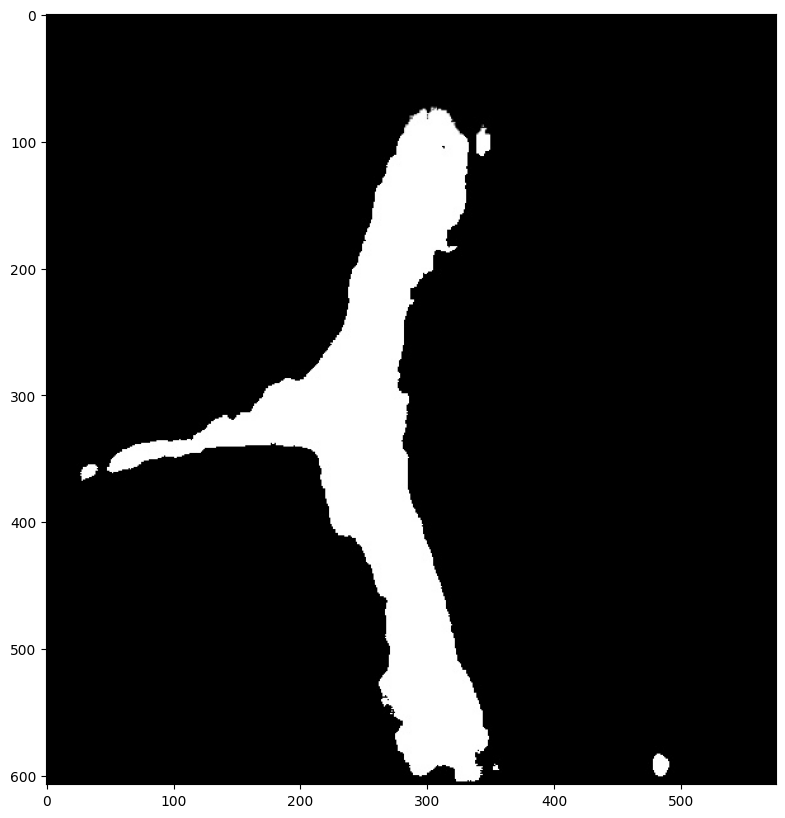

Isotropic closing of segmentation image


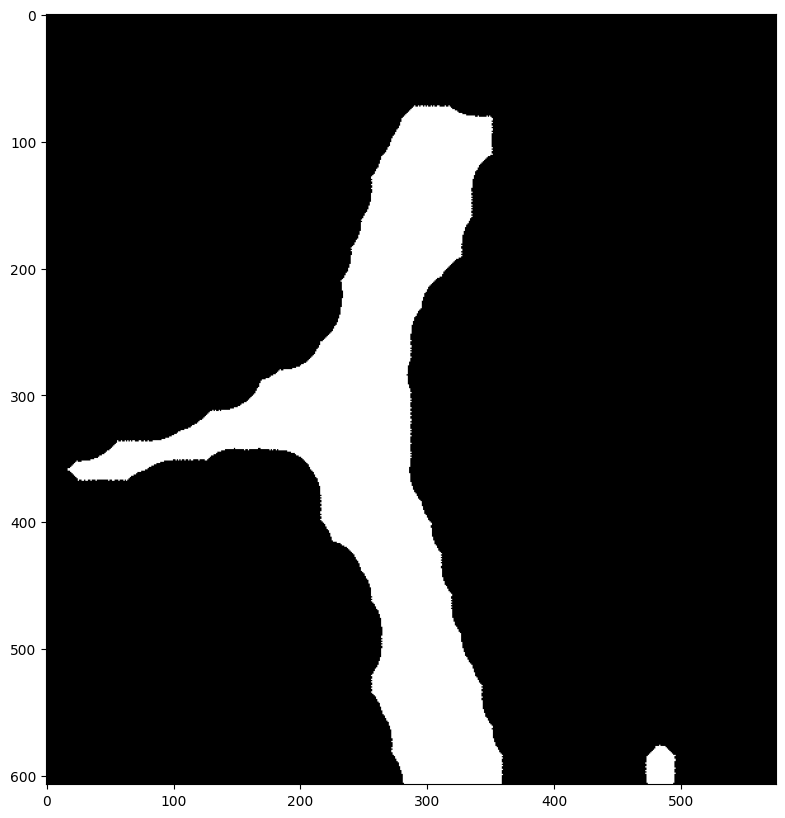

Number of contours: 2
Contour length: 98.66904747486115
Contour area: 561.5
Convex hull area: 594.0


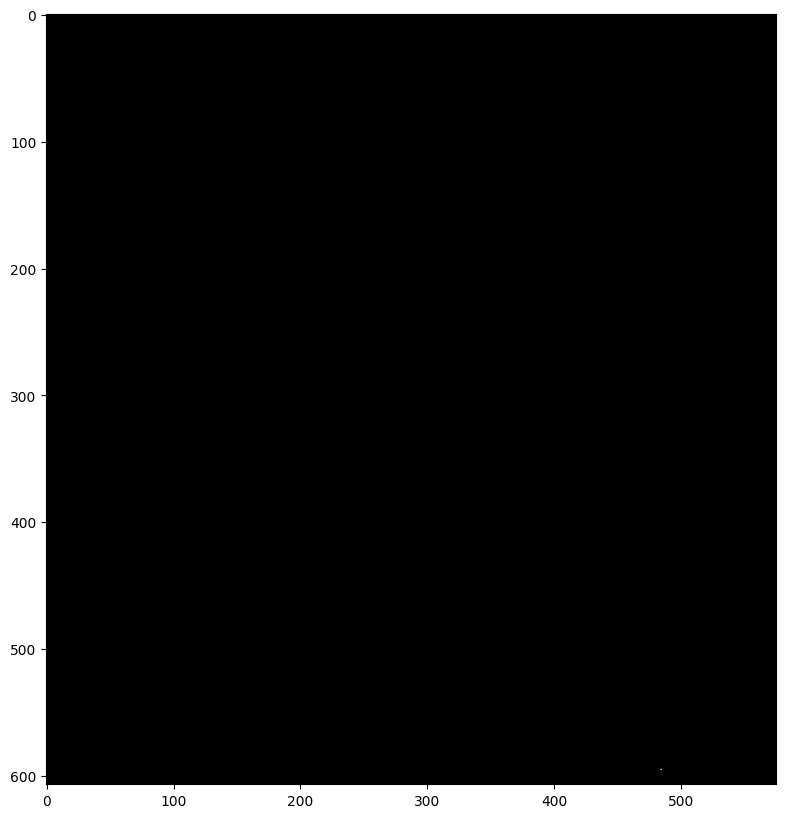

Getting intersections in skeleton (more than 2 neighbours)
0 intersections found in the skeleton
Solidity = 0.9452861952861953 -> no intersection in this contour
Contour length: 1814.1332423686981
Contour area: 45682.5
Convex hull area: 108761.0


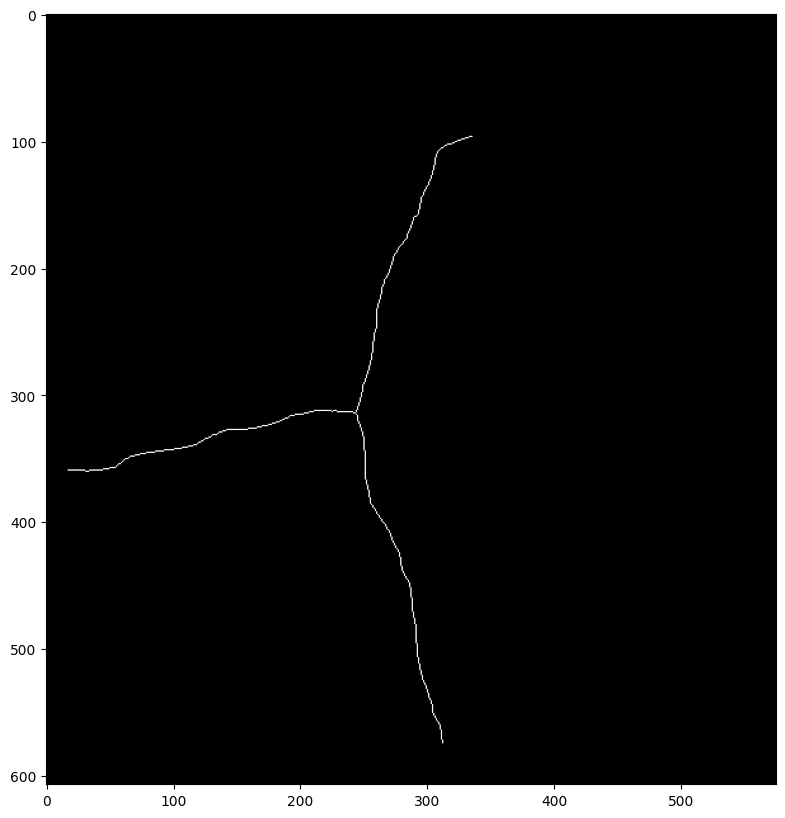

Getting intersections in skeleton (more than 2 neighbours)
1 intersections found in the skeleton
Solidity = 0.4200264800801758 -> this contour can be related to an intersection in the road
Intersection is found in a possible intersection contour, now try and match it with the openstreetmap images
Road neighbour pixels: [(14, 15), (16, 14), (16, 16)]
Number of roads that intersect in this intersection: 3
Patch:


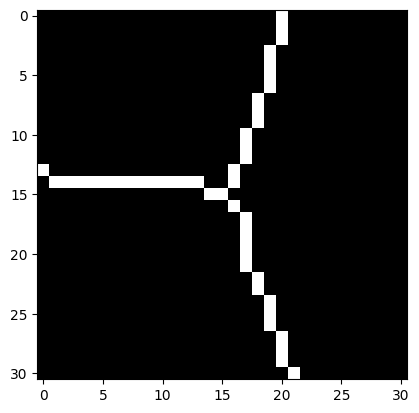

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0 255   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0 255   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0 255   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0 255   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0 255   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0 255   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0 255   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  255   0   0   0   0  

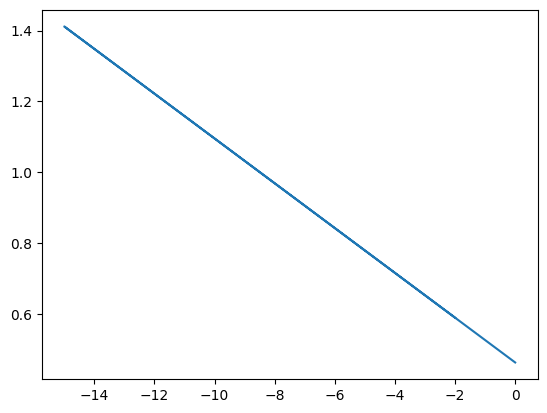

Direction is: 176.38170223086667
Road pixels for neighbour pixel (16, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 1.  2.]
 [ 2.  3.]
 [ 2.  4.]
 [ 2.  5.]
 [ 3.  6.]
 [ 3.  7.]
 [ 3.  8.]
 [ 4.  9.]
 [ 4. 10.]
 [ 4. 11.]
 [ 4. 12.]
 [ 5. 13.]
 [ 5. 14.]
 [ 5. 15.]
 [ 1.  1.]
 [ 0.  0.]]
Line: [ 3.  -1.5]


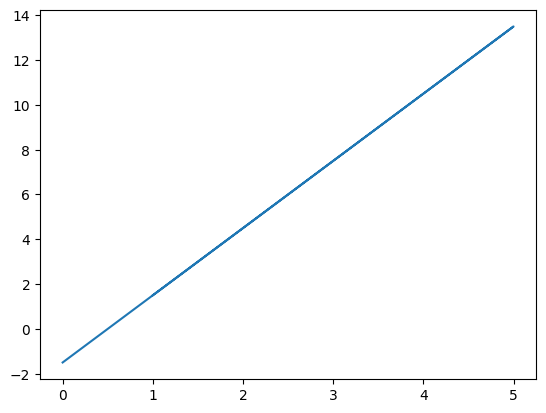

Direction is: 71.56505117707798
Road pixels for neighbour pixel (16, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  2.  -2.]
 [  2.  -3.]
 [  2.  -4.]
 [  2.  -5.]
 [  2.  -6.]
 [  3.  -7.]
 [  3.  -8.]
 [  4.  -9.]
 [  4. -10.]
 [  4. -11.]
 [  5. -12.]
 [  5. -13.]
 [  5. -14.]
 [  6. -15.]
 [  1.  -1.]
 [  0.   0.]]
Line: [-2.77844311  1.18263473]


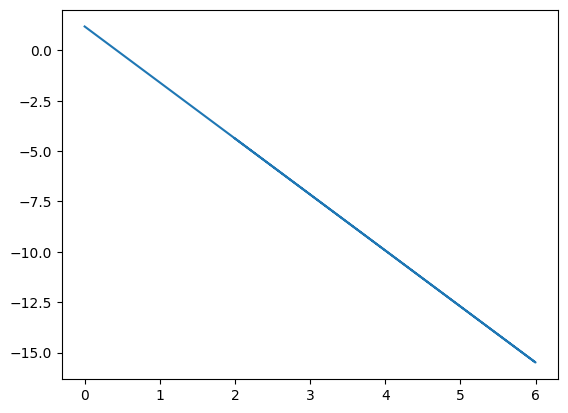

Direction is: 289.79450363229324
Sorted vector of angles: [71.56505117707798, 176.38170223086667, 289.79450363229324]
Array of descriptors: [[71.56505117707798, 176.38170223086667, 289.79450363229324]]


In [44]:
# segm_img_des = find_descriptors_in_segmentation_image(sem_segm_img_path)
segm_img_des = find_descriptors_in_segmentation_image_without_pruning(sem_segm_img_path)
print(f"Array of descriptors: {segm_img_des}")

In [45]:
def find_descriptors_in_mapbox_image(img_path, image_name) : 
    print(f"Finding descriptors in mapbox image {image_name}")
    
    img_bgr = cv2.imread(img_path)
    # print("Mapbox image")
    # plot_image(img_bgr)

    new_width, new_height = img_bgr.shape[1], img_bgr.shape[0] - 100 
    cropped_img_bgr = img_bgr[0:new_height, 0:new_width]
    # print("Cropped mapbox image")
    # plot_image(cropped_img_bgr)

    # print("Binary thresholding")
    img_gray = cv2.cvtColor(cropped_img_bgr, cv2.COLOR_BGR2GRAY)
    ret, thresh_gray = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)
    thresh_bgr = cv2.cvtColor(thresh_gray, cv2.COLOR_GRAY2BGR)
    # plot_image(thresh_bgr)

    img_bgr_copy = img_bgr.copy()

    contours, hierarchy = cv2.findContours(thresh_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # print(f"Number of contours: {len(contours)}")
    cv2.drawContours(img_bgr_copy, contours, contourIdx=-1, color=(255, 0, 0), thickness=2)

    descriptors = []

    for contour in contours :
        contour_length = cv2.arcLength(contour, closed=True)
        # print(f"Contour length: {contour_length}")
        contour_area = cv2.contourArea(contour)
        # print(f"Contour area: {contour_area}")

        # measure the irregularity of the polygon
        if contour_length != 0 :
            convex_hull = cv2.convexHull(contour)
            convex_hull_area = cv2.contourArea(convex_hull)
            # print(f"Convex hull area: {convex_hull_area}")
            cv2.polylines(mask_bgr_copy, [convex_hull], isClosed=True, color=(0, 255, 0), thickness=3)
            if convex_hull_area != 0 :
                solidity = contour_area / convex_hull_area
            else :
                solidity = 0

            # get skeleton of the contour
            skeleton_contour_bgr = get_skeleton(mask_bgr_copy, contour)
            
            # find the intersections in the skeleton
            skel_intersections = get_skeleton_intersection(skeleton_contour_bgr)

            print(f"{len(skel_intersections)} intersections found in the skeleton")

            
            #  make a decision based on the solidity
            if solidity < 0.60 and skel_intersections != [] :
                print(f"Solidity = {solidity} -> this contour can be related to an intersection in the road")

                # further processing
                if skel_intersections == [] : 
                    print("No intersection is found in a possible intersection contour")
                else : 
                    # visualization
                    skeleton_contour_bgr_copy = skeleton_contour_bgr.copy()
                    for intersection in skel_intersections :
                        skeleton_contour_bgr_copy[intersection[1], intersection[0]] = [0, 0, 255]
                    # plot_image(skeleton_contour_bgr_copy)
                    # now try and match intersection with the openstreetmap images
                    print("Intersection is found in a possible intersection contour, now try and match it with the openstreetmap images")
                    for intersection in skel_intersections :
                        patch_size = 31 # needs to be odd number
                        patch, neighbour_road_pixels = get_patch_from_intersection(skeleton_contour_bgr, intersection, patch_size)
                        # print(f"Road neighbour pixels: {neighbour_road_pixels}")
                        # print(f"Number of roads that intersect in this intersection: {len(neighbour_road_pixels)}")
                        # print("Patch:")
                        plt.imshow(patch, cmap='gray')
                        plt.show()
                        # print(patch)
                        descriptor = get_descriptor(patch, neighbour_road_pixels)
                        descriptors.append(descriptor)
            else :
                print(f"Solidity = {solidity} -> no intersection in this contour")
        
    if descriptors == [] :
        return None
    else :
        return descriptors

**************************************************
Mapbox image: 50.7771783_3.520804.png
**************************************************
Finding descriptors in mapbox image 50.7771783_3.520804.png
Getting intersections in skeleton (more than 2 neighbours)
1 intersections found in the skeleton
Solidity = 0.19519519519519518 -> this contour can be related to an intersection in the road
Intersection is found in a possible intersection contour, now try and match it with the openstreetmap images


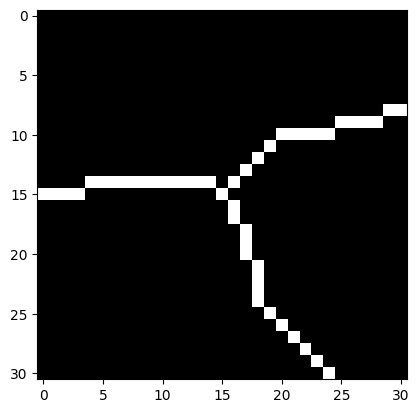

Road pixels for neighbour pixel (14, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.   1.]
 [ -3.   1.]
 [ -4.   1.]
 [ -5.   1.]
 [ -6.   1.]
 [ -7.   1.]
 [ -8.   1.]
 [ -9.   1.]
 [-10.   1.]
 [-11.   1.]
 [-12.   0.]
 [-13.   0.]
 [-14.   0.]
 [-15.   0.]
 [ -1.   1.]
 [  0.   0.]]
Line: [0.04852941 1.05147059]


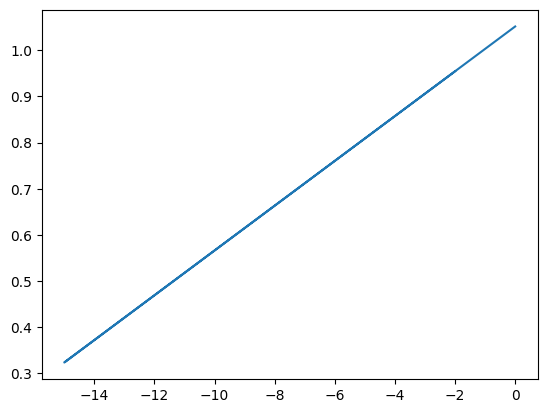

Direction is: 182.77835074300506
Road pixels for neighbour pixel (16, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2.  2.]
 [ 3.  3.]
 [ 4.  4.]
 [ 5.  5.]
 [ 6.  5.]
 [ 7.  5.]
 [ 8.  5.]
 [ 9.  5.]
 [10.  6.]
 [11.  6.]
 [12.  6.]
 [13.  6.]
 [14.  7.]
 [15.  7.]
 [ 1.  1.]
 [ 0.  0.]]
Line: [0.40147059 1.55147059]


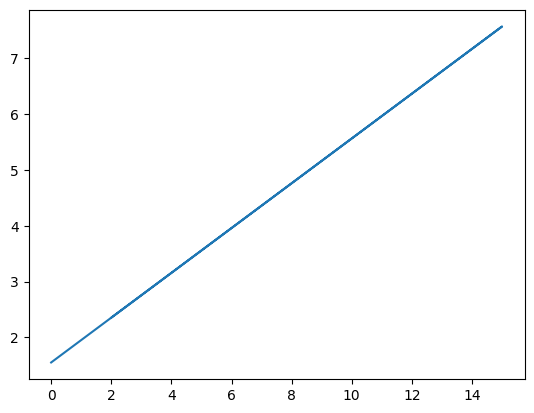

Direction is: 21.87400926948565
Road pixels for neighbour pixel (16, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  1.  -2.]
 [  2.  -3.]
 [  2.  -4.]
 [  2.  -5.]
 [  3.  -6.]
 [  3.  -7.]
 [  3.  -8.]
 [  3.  -9.]
 [  4. -10.]
 [  5. -11.]
 [  6. -12.]
 [  7. -13.]
 [  8. -14.]
 [  9. -15.]
 [  1.  -1.]
 [  0.   0.]]
Line: [-1.73534743 -1.10090634]


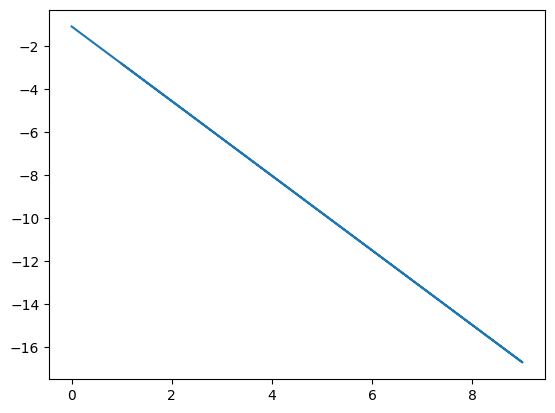

Direction is: 299.95284665414937
Sorted vector of angles: [21.87400926948565, 182.77835074300506, 299.95284665414937]
Getting intersections in skeleton (more than 2 neighbours)
0 intersections found in the skeleton
Solidity = 0.84 -> no intersection in this contour
Descriptors: [[21.87400926948565, 182.77835074300506, 299.95284665414937]] for mapbox image 50.7771783_3.520804.png
Number of descriptors: 1
Descriptor of segmentation image:
[71.56505117707798, 176.38170223086667, 289.79450363229324]
Descriptor of mapbox image:
[21.87400926948565, 182.77835074300506, 299.95284665414937]
x = 71.56505117707798, y = 21.87400926948565
x = 176.38170223086667, y = 182.77835074300506
x = 289.79450363229324, y = 299.95284665414937
Result = 51.120531012496656
**************************************************
Mapbox image: 50.776741_3.5254172.png
**************************************************
Finding descriptors in mapbox image 50.776741_3.5254172.png
Getting intersections in skeleton (more than

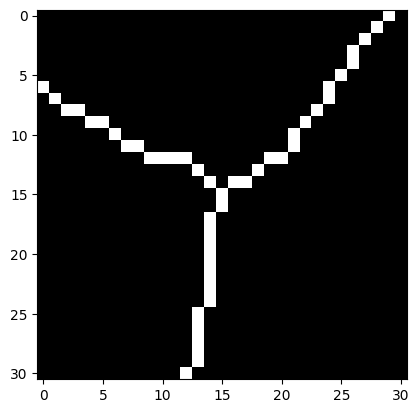

Road pixels for neighbour pixel (14, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.   2.]
 [ -3.   3.]
 [ -4.   3.]
 [ -5.   3.]
 [ -6.   3.]
 [ -7.   4.]
 [ -8.   4.]
 [ -9.   5.]
 [-10.   6.]
 [-11.   6.]
 [-12.   7.]
 [-13.   7.]
 [-14.   8.]
 [-15.   9.]
 [ -1.   1.]
 [  0.   0.]]
Line: [-0.52794118  0.47794118]


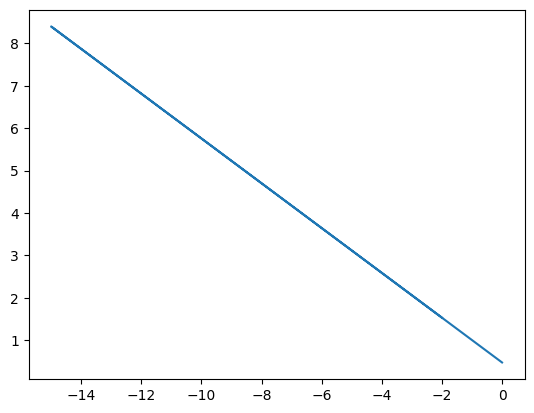

Direction is: 152.16858170536673
Road pixels for neighbour pixel (15, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -1.  -2.]
 [ -1.  -3.]
 [ -1.  -4.]
 [ -1.  -5.]
 [ -1.  -6.]
 [ -1.  -7.]
 [ -1.  -8.]
 [ -1.  -9.]
 [ -2. -10.]
 [ -2. -11.]
 [ -2. -12.]
 [ -2. -13.]
 [ -2. -14.]
 [ -3. -15.]
 [  0.  -1.]
 [  0.   0.]]
Line: [ 5.45695364 -0.33774834]


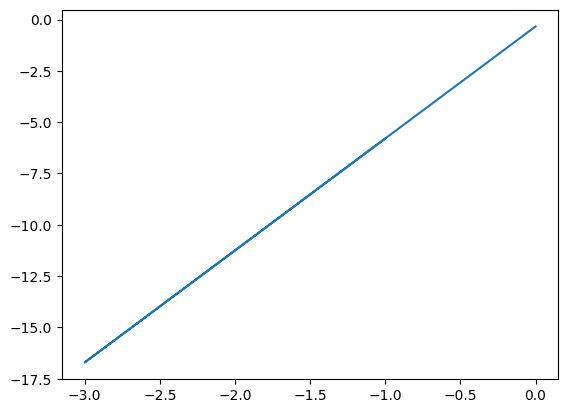

Direction is: 259.6156270892795
Road pixels for neighbour pixel (16, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2.  1.]
 [ 3.  2.]
 [ 4.  3.]
 [ 5.  3.]
 [ 6.  4.]
 [ 6.  5.]
 [ 7.  6.]
 [ 8.  7.]
 [ 9.  8.]
 [ 9.  9.]
 [10. 10.]
 [11. 11.]
 [11. 12.]
 [12. 13.]
 [13. 14.]
 [14. 15.]
 [ 1.  1.]
 [ 0.  0.]]
Line: [ 1.13332097 -1.35916929]


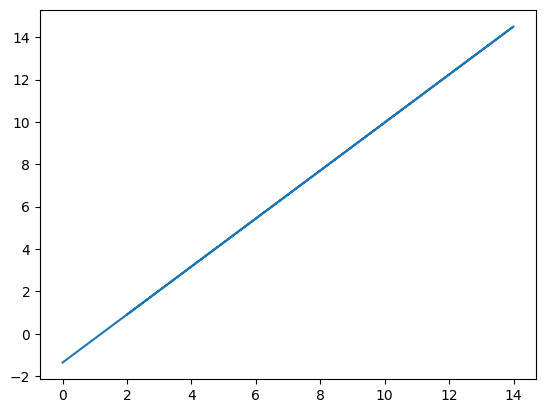

Direction is: 48.5760243312227
Sorted vector of angles: [48.5760243312227, 152.16858170536673, 259.6156270892795]


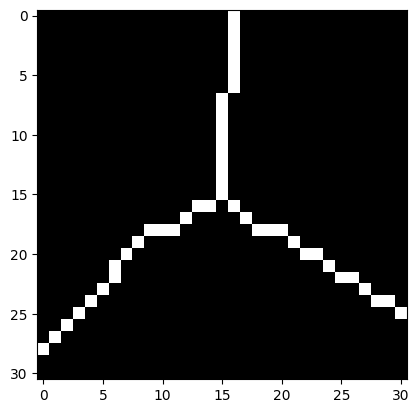

Road pixels for neighbour pixel (14, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.  -1.]
 [ -3.  -2.]
 [ -4.  -3.]
 [ -5.  -3.]
 [ -6.  -3.]
 [ -7.  -4.]
 [ -8.  -5.]
 [ -9.  -6.]
 [ -9.  -7.]
 [-10.  -8.]
 [-11.  -9.]
 [-12. -10.]
 [-13. -11.]
 [-14. -12.]
 [-15. -13.]
 [ -1.  -1.]
 [  0.   0.]]
Line: [0.87792297 0.89718019]


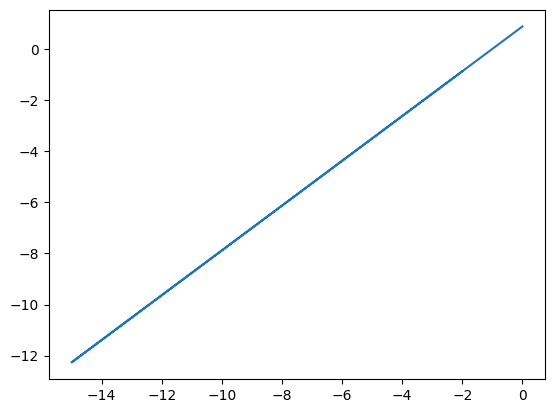

Direction is: 221.28064035856008
Road pixels for neighbour pixel (15, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 0.  2.]
 [ 0.  3.]
 [ 0.  4.]
 [ 0.  5.]
 [ 0.  6.]
 [ 0.  7.]
 [ 0.  8.]
 [ 1.  9.]
 [ 1. 10.]
 [ 1. 11.]
 [ 1. 12.]
 [ 1. 13.]
 [ 1. 14.]
 [ 1. 15.]
 [ 0.  1.]
 [ 0.  0.]]
Line: [8. 4.]


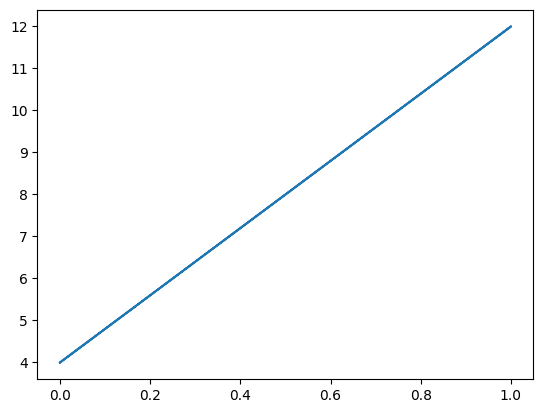

Direction is: 82.8749836510982
Road pixels for neighbour pixel (16, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  2.  -2.]
 [  3.  -3.]
 [  4.  -3.]
 [  5.  -3.]
 [  6.  -4.]
 [  7.  -5.]
 [  8.  -5.]
 [  9.  -6.]
 [ 10.  -7.]
 [ 11.  -7.]
 [ 12.  -8.]
 [ 13.  -9.]
 [ 14.  -9.]
 [ 15. -10.]
 [  1.  -1.]
 [  0.   0.]]
Line: [-0.63235294 -0.38235294]


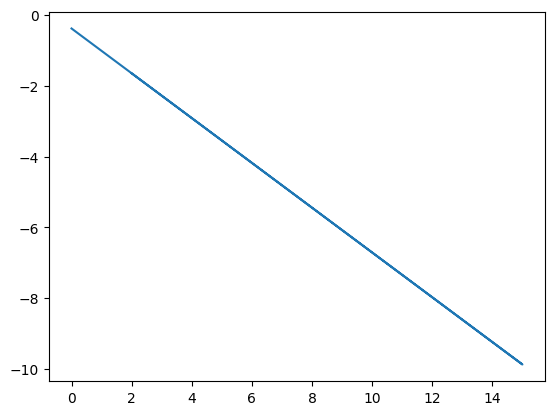

Direction is: 327.6926655451179
Sorted vector of angles: [82.8749836510982, 221.28064035856008, 327.6926655451179]
Descriptors: [[48.5760243312227, 152.16858170536673, 259.6156270892795], [82.8749836510982, 221.28064035856008, 327.6926655451179]] for mapbox image 50.776741_3.5254172.png
Number of descriptors: 2
Descriptor of segmentation image:
[71.56505117707798, 176.38170223086667, 289.79450363229324]
Descriptor of mapbox image:
[48.5760243312227, 152.16858170536673, 259.6156270892795]
x = 71.56505117707798, y = 48.5760243312227
x = 176.38170223086667, y = 152.16858170536673
x = 289.79450363229324, y = 259.6156270892795
Result = 45.00594572165223
Descriptor of mapbox image:
[82.8749836510982, 221.28064035856008, 327.6926655451179]
x = 71.56505117707798, y = 82.8749836510982
x = 176.38170223086667, y = 221.28064035856008
x = 289.79450363229324, y = 327.6926655451179
Result = 59.83393597225585
**************************************************
Mapbox image: 50.7766227_3.5233649.png
***

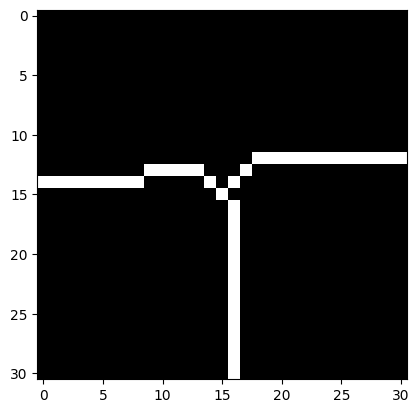

Road pixels for neighbour pixel (14, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.   2.]
 [ -3.   2.]
 [ -4.   2.]
 [ -5.   2.]
 [ -6.   2.]
 [ -7.   1.]
 [ -8.   1.]
 [ -9.   1.]
 [-10.   1.]
 [-11.   1.]
 [-12.   1.]
 [-13.   1.]
 [-14.   1.]
 [-15.   1.]
 [ -1.   1.]
 [  0.   0.]]
Line: [0.02941176 1.47058824]


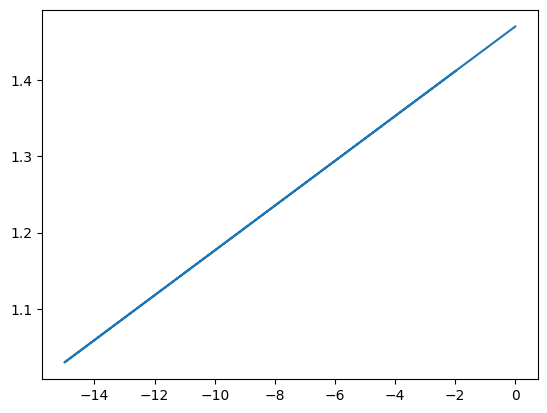

Direction is: 181.68468431789628
Road pixels for neighbour pixel (16, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2.  2.]
 [ 3.  3.]
 [ 4.  3.]
 [ 5.  3.]
 [ 6.  3.]
 [ 7.  3.]
 [ 8.  3.]
 [ 9.  3.]
 [10.  3.]
 [11.  3.]
 [12.  3.]
 [13.  3.]
 [14.  3.]
 [15.  3.]
 [ 1.  1.]
 [ 0.  0.]]
Line: [0.12058824 1.72058824]


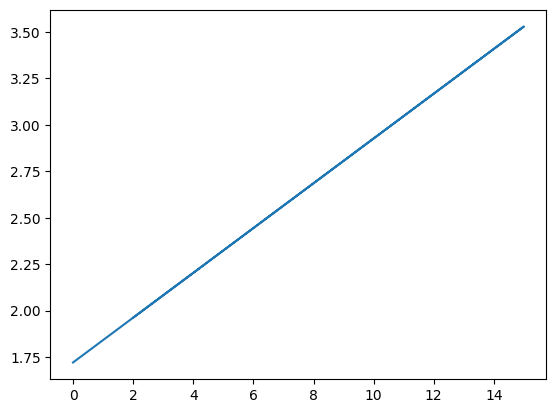

Direction is: 6.875996057355376
Road pixels for neighbour pixel (16, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  1.  -2.]
 [  1.  -3.]
 [  1.  -4.]
 [  1.  -5.]
 [  1.  -6.]
 [  1.  -7.]
 [  1.  -8.]
 [  1.  -9.]
 [  1. -10.]
 [  1. -11.]
 [  1. -12.]
 [  1. -13.]
 [  1. -14.]
 [  1. -15.]
 [  1.  -1.]
 [  0.   0.]]
Line: [-8.00000000e+00 -3.03495633e-15]


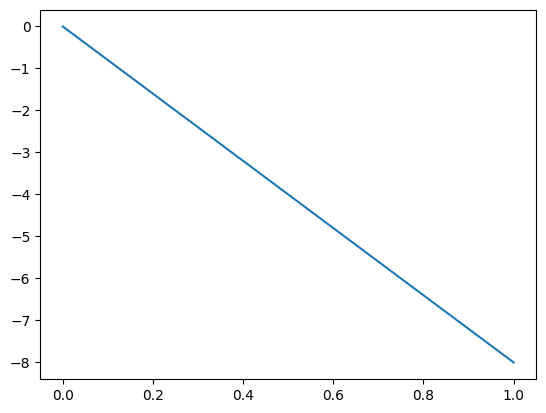

Direction is: 277.1250163489018
Sorted vector of angles: [6.875996057355376, 181.68468431789628, 277.1250163489018]
Descriptors: [[6.875996057355376, 181.68468431789628, 277.1250163489018]] for mapbox image 50.7766227_3.5233649.png
Number of descriptors: 1
Descriptor of segmentation image:
[71.56505117707798, 176.38170223086667, 289.79450363229324]
Descriptor of mapbox image:
[6.875996057355376, 181.68468431789628, 277.1250163489018]
x = 71.56505117707798, y = 6.875996057355376
x = 176.38170223086667, y = 181.68468431789628
x = 289.79450363229324, y = 277.1250163489018
Result = 66.13101677217645
**************************************************
Mapbox image: 50.7788689_3.5254466.png
**************************************************
Finding descriptors in mapbox image 50.7788689_3.5254466.png
Getting intersections in skeleton (more than 2 neighbours)
2 intersections found in the skeleton
Solidity = 0.10245955156043993 -> this contour can be related to an intersection in the road
Inter

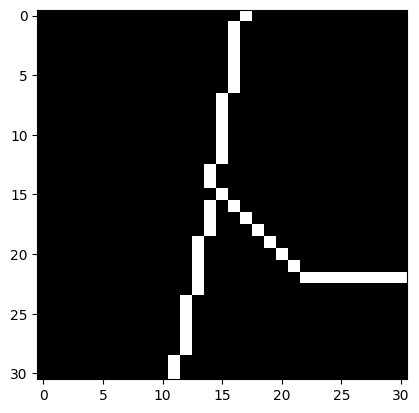

Road pixels for neighbour pixel (14, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[-1.  2.]
 [ 0.  3.]
 [ 0.  4.]
 [ 0.  5.]
 [ 0.  6.]
 [ 0.  7.]
 [ 0.  8.]
 [ 1.  9.]
 [ 1. 10.]
 [ 1. 11.]
 [ 1. 12.]
 [ 1. 13.]
 [ 1. 14.]
 [ 2. 15.]
 [-1.  1.]
 [ 0.  0.]]
Line: [5.23076923 5.53846154]


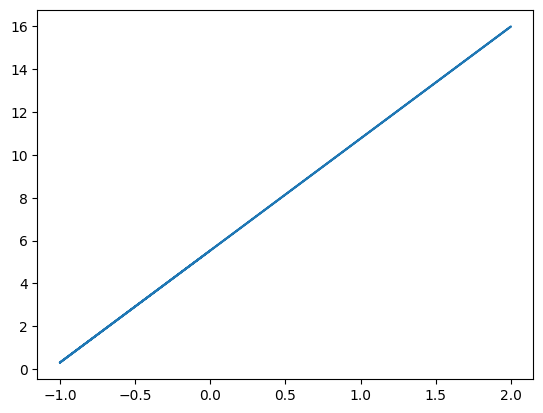

Direction is: 259.1769887737929
Road pixels for neighbour pixel (14, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -1.  -2.]
 [ -1.  -3.]
 [ -2.  -4.]
 [ -2.  -5.]
 [ -2.  -6.]
 [ -2.  -7.]
 [ -2.  -8.]
 [ -3.  -9.]
 [ -3. -10.]
 [ -3. -11.]
 [ -3. -12.]
 [ -3. -13.]
 [ -4. -14.]
 [ -4. -15.]
 [ -1.  -1.]
 [  0.   0.]]
Line: [4.05263158 1.61842105]


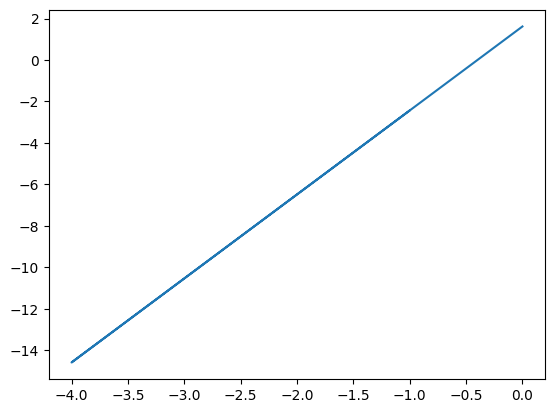

Direction is: 256.13897243697886
Road pixels for neighbour pixel (16, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2. -2.]
 [ 3. -3.]
 [ 4. -4.]
 [ 5. -5.]
 [ 6. -6.]
 [ 7. -7.]
 [ 8. -7.]
 [ 9. -7.]
 [10. -7.]
 [11. -7.]
 [12. -7.]
 [13. -7.]
 [14. -7.]
 [15. -7.]
 [ 1. -1.]
 [ 0.  0.]]
Line: [-0.45294118 -1.85294118]


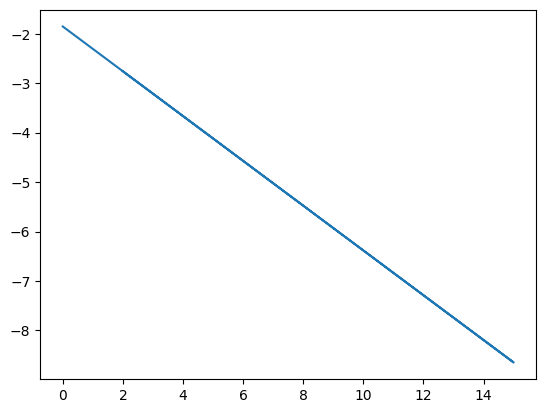

Direction is: 335.6322701584444
Sorted vector of angles: [256.13897243697886, 259.1769887737929, 335.6322701584444]


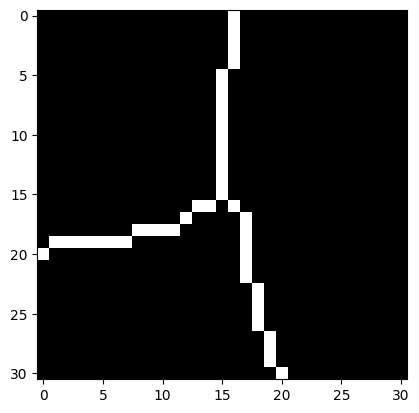

Road pixels for neighbour pixel (14, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.  -1.]
 [ -3.  -2.]
 [ -4.  -3.]
 [ -5.  -3.]
 [ -6.  -3.]
 [ -7.  -3.]
 [ -8.  -4.]
 [ -9.  -4.]
 [-10.  -4.]
 [-11.  -4.]
 [-12.  -4.]
 [-13.  -4.]
 [-14.  -4.]
 [-15.  -5.]
 [ -1.  -1.]
 [  0.   0.]]
Line: [ 0.26617647 -1.06617647]


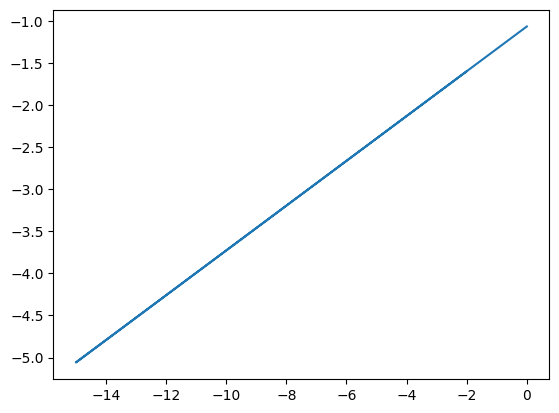

Direction is: 194.90519245481642
Road pixels for neighbour pixel (15, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 0.  2.]
 [ 0.  3.]
 [ 0.  4.]
 [ 0.  5.]
 [ 0.  6.]
 [ 0.  7.]
 [ 0.  8.]
 [ 0.  9.]
 [ 0. 10.]
 [ 1. 11.]
 [ 1. 12.]
 [ 1. 13.]
 [ 1. 14.]
 [ 1. 15.]
 [ 0.  1.]
 [ 0.  0.]]
Line: [8. 5.]


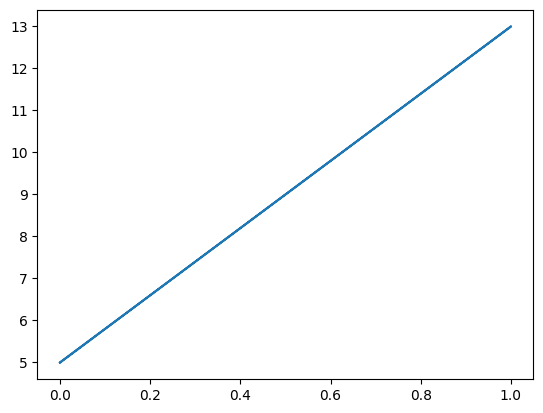

Direction is: 82.87498365109822
Road pixels for neighbour pixel (16, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  2.  -2.]
 [  2.  -3.]
 [  2.  -4.]
 [  2.  -5.]
 [  2.  -6.]
 [  2.  -7.]
 [  3.  -8.]
 [  3.  -9.]
 [  3. -10.]
 [  3. -11.]
 [  4. -12.]
 [  4. -13.]
 [  4. -14.]
 [  5. -15.]
 [  1.  -1.]
 [  0.   0.]]
Line: [-3.57894737  1.89473684]


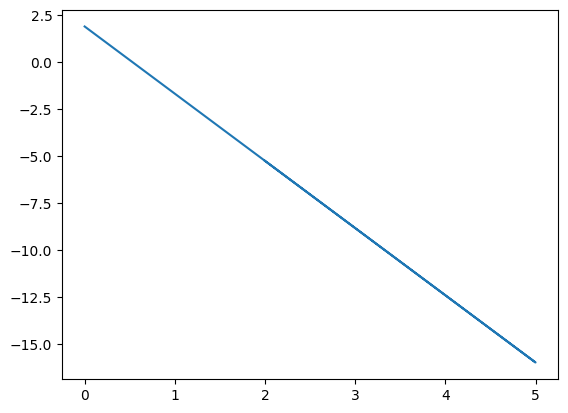

Direction is: 285.6109885336797
Sorted vector of angles: [82.87498365109822, 194.90519245481642, 285.6109885336797]
Descriptors: [[256.13897243697886, 259.1769887737929, 335.6322701584444], [82.87498365109822, 194.90519245481642, 285.6109885336797]] for mapbox image 50.7788689_3.5254466.png
Number of descriptors: 2
Descriptor of segmentation image:
[71.56505117707798, 176.38170223086667, 289.79450363229324]
Descriptor of mapbox image:
[256.13897243697886, 259.1769887737929, 335.6322701584444]
x = 71.56505117707798, y = 256.13897243697886
x = 176.38170223086667, y = 259.1769887737929
x = 289.79450363229324, y = 335.6322701584444
Result = 207.42153389435558
Descriptor of mapbox image:
[82.87498365109822, 194.90519245481642, 285.6109885336797]
x = 71.56505117707798, y = 82.87498365109822
x = 176.38170223086667, y = 194.90519245481642
x = 289.79450363229324, y = 285.6109885336797
Result = 22.102851879881637
**************************************************
Mapbox image: 50.7749412_3.52280

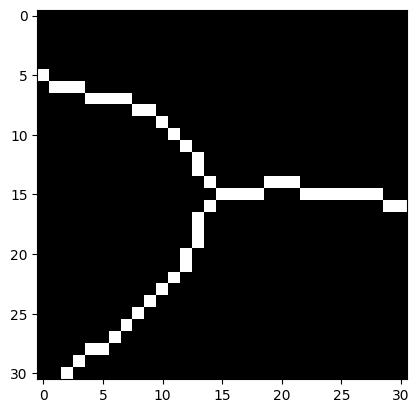

Road pixels for neighbour pixel (14, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.   2.]
 [ -2.   3.]
 [ -3.   4.]
 [ -4.   5.]
 [ -5.   6.]
 [ -6.   7.]
 [ -7.   7.]
 [ -8.   8.]
 [ -9.   8.]
 [-10.   8.]
 [-11.   8.]
 [-12.   9.]
 [-13.   9.]
 [-14.   9.]
 [-15.  10.]
 [ -1.   1.]
 [  0.   0.]]
Line: [-0.60424649  1.78128991]


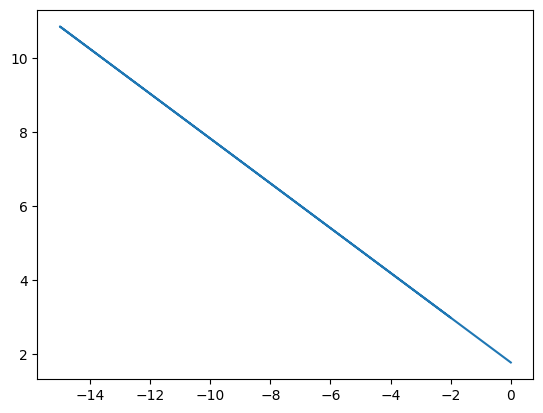

Direction is: 148.8576772346961
Road pixels for neighbour pixel (14, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.  -2.]
 [ -2.  -3.]
 [ -2.  -4.]
 [ -3.  -5.]
 [ -3.  -6.]
 [ -4.  -7.]
 [ -5.  -8.]
 [ -6.  -9.]
 [ -7. -10.]
 [ -8. -11.]
 [ -9. -12.]
 [-10. -13.]
 [-11. -13.]
 [-12. -14.]
 [-13. -15.]
 [ -1.  -1.]
 [  0.   0.]]
Line: [ 1.14105903 -1.24565972]


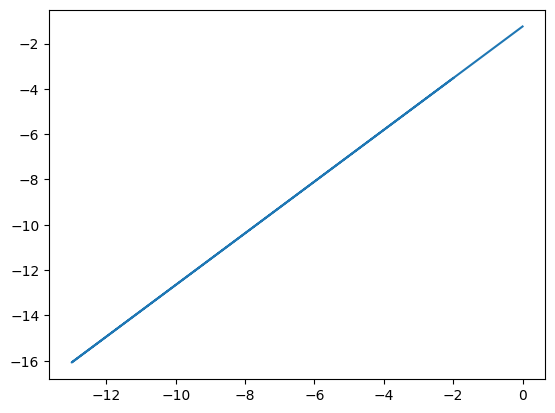

Direction is: 228.76936069896854
Road pixels for neighbour pixel (16, 15) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2.  0.]
 [ 3.  0.]
 [ 4.  1.]
 [ 5.  1.]
 [ 6.  1.]
 [ 7.  0.]
 [ 8.  0.]
 [ 9.  0.]
 [10.  0.]
 [11.  0.]
 [12.  0.]
 [13.  0.]
 [14. -1.]
 [15. -1.]
 [ 1.  0.]
 [ 0.  0.]]
Line: [-0.06323529  0.53676471]


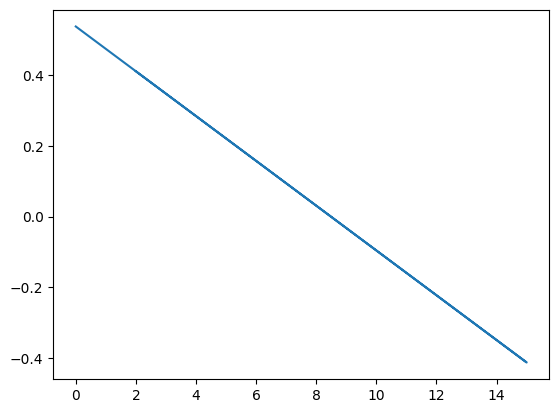

Direction is: 356.38170223086667
Sorted vector of angles: [148.8576772346961, 228.76936069896854, 356.38170223086667]
Descriptors: [[148.8576772346961, 228.76936069896854, 356.38170223086667]] for mapbox image 50.7749412_3.5228001.png
Number of descriptors: 1
Descriptor of segmentation image:
[71.56505117707798, 176.38170223086667, 289.79450363229324]
Descriptor of mapbox image:
[148.8576772346961, 228.76936069896854, 356.38170223086667]
x = 71.56505117707798, y = 148.8576772346961
x = 176.38170223086667, y = 228.76936069896854
x = 289.79450363229324, y = 356.38170223086667
Result = 114.684226552125
**************************************************
Mapbox image: 50.7772325_3.5239031.png
**************************************************
Finding descriptors in mapbox image 50.7772325_3.5239031.png
Getting intersections in skeleton (more than 2 neighbours)
0 intersections found in the skeleton
Solidity = 0.9482420232153872 -> no intersection in this contour
Getting intersections in skel

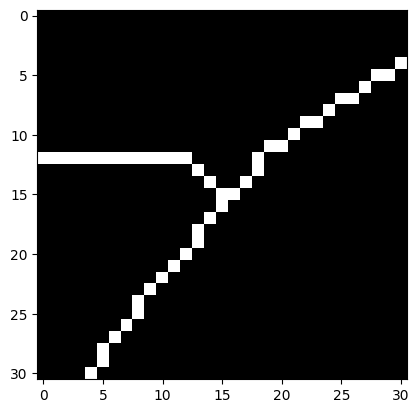

Road pixels for neighbour pixel (14, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.   2.]
 [ -3.   3.]
 [ -4.   3.]
 [ -5.   3.]
 [ -6.   3.]
 [ -7.   3.]
 [ -8.   3.]
 [ -9.   3.]
 [-10.   3.]
 [-11.   3.]
 [-12.   3.]
 [-13.   3.]
 [-14.   3.]
 [-15.   3.]
 [ -1.   1.]
 [  0.   0.]]
Line: [-0.12058824  1.72058824]


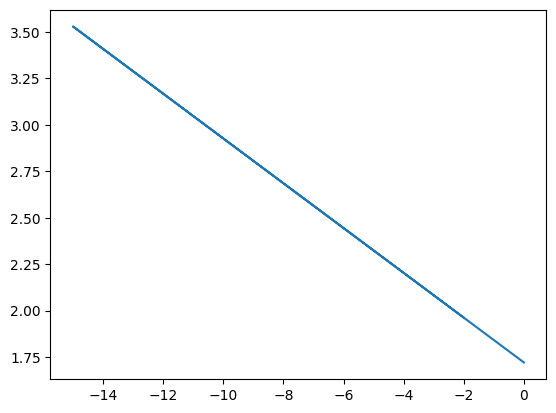

Direction is: 173.12400394264463
Road pixels for neighbour pixel (15, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -1.  -2.]
 [ -2.  -3.]
 [ -2.  -4.]
 [ -3.  -5.]
 [ -4.  -6.]
 [ -5.  -7.]
 [ -6.  -8.]
 [ -7.  -9.]
 [ -7. -10.]
 [ -8. -11.]
 [ -9. -12.]
 [-10. -13.]
 [-10. -14.]
 [-11. -15.]
 [  0.  -1.]
 [  0.   0.]]
Line: [ 1.27508286 -0.72612233]


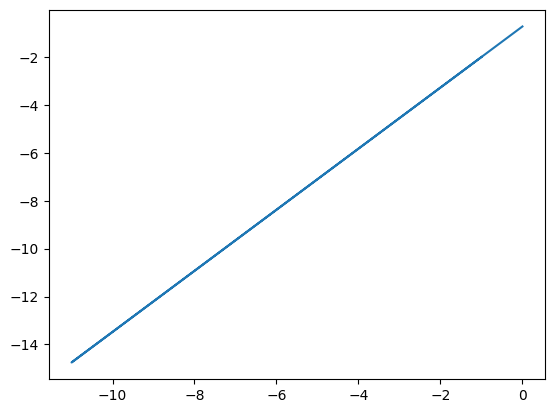

Direction is: 231.89423112030045
Road pixels for neighbour pixel (16, 15) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2.  1.]
 [ 3.  2.]
 [ 3.  3.]
 [ 4.  4.]
 [ 5.  4.]
 [ 6.  5.]
 [ 7.  6.]
 [ 8.  6.]
 [ 9.  7.]
 [10.  8.]
 [11.  8.]
 [12.  9.]
 [13. 10.]
 [14. 10.]
 [15. 11.]
 [ 1.  0.]
 [ 0.  0.]]
Line: [0.74328309 0.15153997]


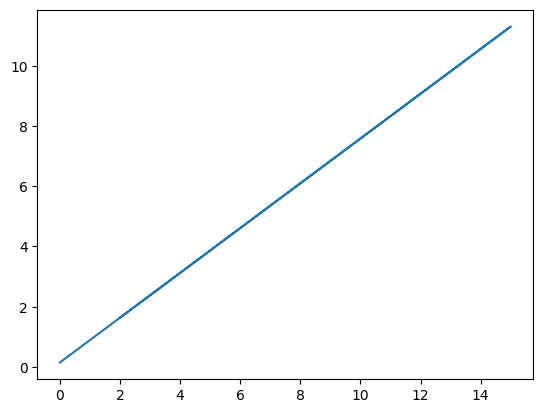

Direction is: 36.62279822743854
Sorted vector of angles: [36.62279822743854, 173.12400394264463, 231.89423112030045]


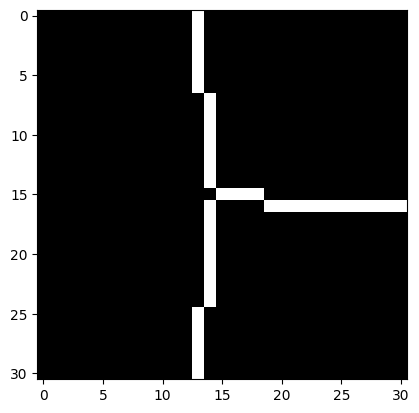

Road pixels for neighbour pixel (14, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[-1.  2.]
 [-1.  3.]
 [-1.  4.]
 [-1.  5.]
 [-1.  6.]
 [-1.  7.]
 [-1.  8.]
 [-2.  9.]
 [-2. 10.]
 [-2. 11.]
 [-2. 12.]
 [-2. 13.]
 [-2. 14.]
 [-2. 15.]
 [-1.  1.]
 [ 0.  0.]]
Line: [-6.7826087  -1.82608696]


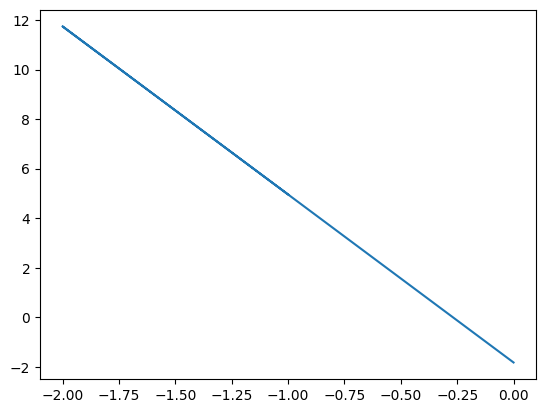

Direction is: 98.3870323786595
Road pixels for neighbour pixel (14, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -1.  -2.]
 [ -1.  -3.]
 [ -1.  -4.]
 [ -1.  -5.]
 [ -1.  -6.]
 [ -1.  -7.]
 [ -1.  -8.]
 [ -1.  -9.]
 [ -2. -10.]
 [ -2. -11.]
 [ -2. -12.]
 [ -2. -13.]
 [ -2. -14.]
 [ -2. -15.]
 [ -1.  -1.]
 [  0.   0.]]
Line: [6.89655172 1.55172414]


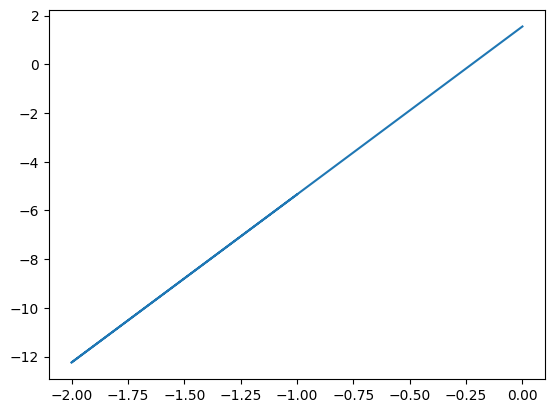

Direction is: 261.7496127710945
Road pixels for neighbour pixel (16, 15) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2.  0.]
 [ 3.  0.]
 [ 4. -1.]
 [ 5. -1.]
 [ 6. -1.]
 [ 7. -1.]
 [ 8. -1.]
 [ 9. -1.]
 [10. -1.]
 [11. -1.]
 [12. -1.]
 [13. -1.]
 [14. -1.]
 [15. -1.]
 [ 1.  0.]
 [ 0.  0.]]
Line: [-0.07058824 -0.22058824]


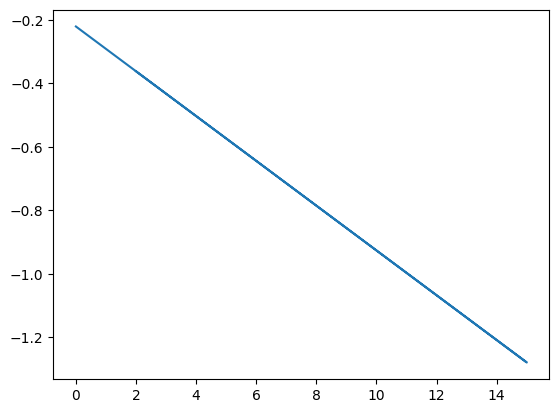

Direction is: 355.9622893790229
Sorted vector of angles: [98.3870323786595, 261.7496127710945, 355.9622893790229]
Descriptors: [[36.62279822743854, 173.12400394264463, 231.89423112030045], [98.3870323786595, 261.7496127710945, 355.9622893790229]] for mapbox image 50.7749296_3.5262874.png
Number of descriptors: 2
Descriptor of segmentation image:
[71.56505117707798, 176.38170223086667, 289.79450363229324]
Descriptor of mapbox image:
[36.62279822743854, 173.12400394264463, 231.89423112030045]
x = 71.56505117707798, y = 36.62279822743854
x = 176.38170223086667, y = 173.12400394264463
x = 289.79450363229324, y = 231.89423112030045
Result = 67.70535574307766
Descriptor of mapbox image:
[98.3870323786595, 261.7496127710945, 355.9622893790229]
x = 71.56505117707798, y = 98.3870323786595
x = 176.38170223086667, y = 261.7496127710945
x = 289.79450363229324, y = 355.9622893790229
Result = 111.289149049705
**************************************************
Mapbox image: 50.7756171_3.5245493.png
*

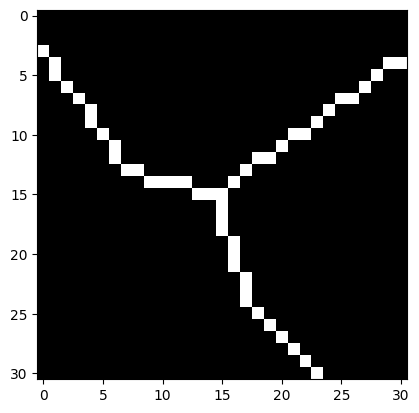

Road pixels for neighbour pixel (14, 15) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.   0.]
 [ -3.   1.]
 [ -4.   1.]
 [ -5.   1.]
 [ -6.   1.]
 [ -7.   2.]
 [ -8.   2.]
 [ -9.   3.]
 [ -9.   4.]
 [-10.   5.]
 [-11.   6.]
 [-11.   7.]
 [-12.   8.]
 [-13.   9.]
 [-14.  10.]
 [-14.  11.]
 [-15.  12.]
 [ -1.   0.]
 [  0.   0.]]
Line: [-0.81650014 -2.24952741]


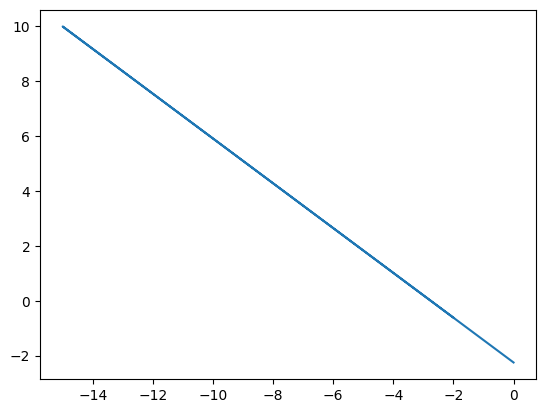

Direction is: 140.7683573357337
Road pixels for neighbour pixel (15, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  0.  -2.]
 [  0.  -3.]
 [  1.  -4.]
 [  1.  -5.]
 [  1.  -6.]
 [  2.  -7.]
 [  2.  -8.]
 [  2.  -9.]
 [  3. -10.]
 [  4. -11.]
 [  5. -12.]
 [  6. -13.]
 [  7. -14.]
 [  8. -15.]
 [  0.  -1.]
 [  0.   0.]]
Line: [-1.71566265 -2.99638554]


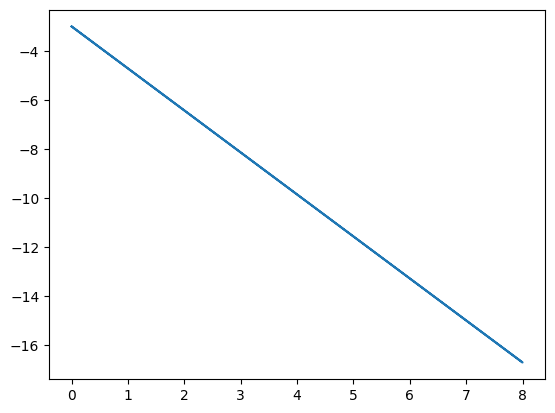

Direction is: 300.2364194232264
Road pixels for neighbour pixel (16, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2.  2.]
 [ 3.  3.]
 [ 4.  3.]
 [ 5.  4.]
 [ 6.  5.]
 [ 7.  5.]
 [ 8.  6.]
 [ 9.  7.]
 [10.  8.]
 [11.  8.]
 [12.  9.]
 [13. 10.]
 [14. 11.]
 [15. 11.]
 [ 1.  1.]
 [ 0.  0.]]
Line: [0.73382353 0.30882353]


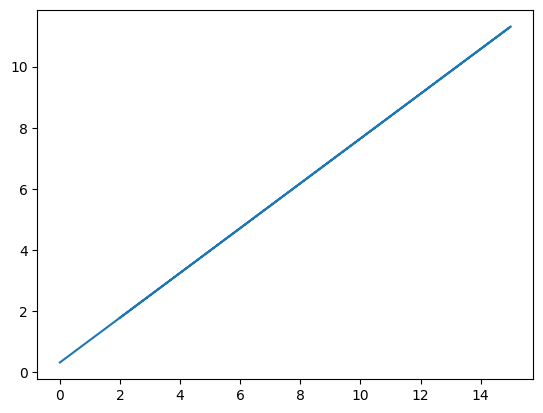

Direction is: 36.27209759389623
Sorted vector of angles: [36.27209759389623, 140.7683573357337, 300.2364194232264]
Descriptors: [[36.27209759389623, 140.7683573357337, 300.2364194232264]] for mapbox image 50.7756171_3.5245493.png
Number of descriptors: 1
Descriptor of segmentation image:
[71.56505117707798, 176.38170223086667, 289.79450363229324]
Descriptor of mapbox image:
[36.27209759389623, 140.7683573357337, 300.2364194232264]
x = 71.56505117707798, y = 36.27209759389623
x = 176.38170223086667, y = 140.7683573357337
x = 289.79450363229324, y = 300.2364194232264
Result = 51.21461229599667
**************************************************
Mapbox image: 50.7768849_3.522932.png
**************************************************
Finding descriptors in mapbox image 50.7768849_3.522932.png
Getting intersections in skeleton (more than 2 neighbours)
1 intersections found in the skeleton
Solidity = 0.21591002231228087 -> this contour can be related to an intersection in the road
Intersectio

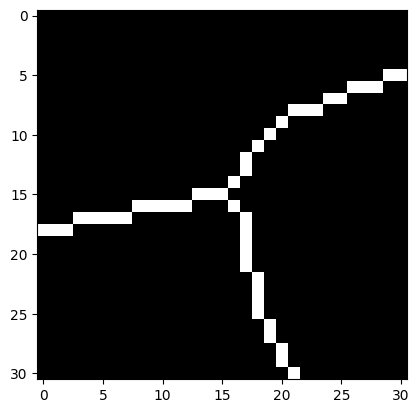

Road pixels for neighbour pixel (14, 15) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.   0.]
 [ -3.  -1.]
 [ -4.  -1.]
 [ -5.  -1.]
 [ -6.  -1.]
 [ -7.  -1.]
 [ -8.  -2.]
 [ -9.  -2.]
 [-10.  -2.]
 [-11.  -2.]
 [-12.  -2.]
 [-13.  -3.]
 [-14.  -3.]
 [-15.  -3.]
 [ -1.   0.]
 [  0.   0.]]
Line: [0.20882353 0.06617647]


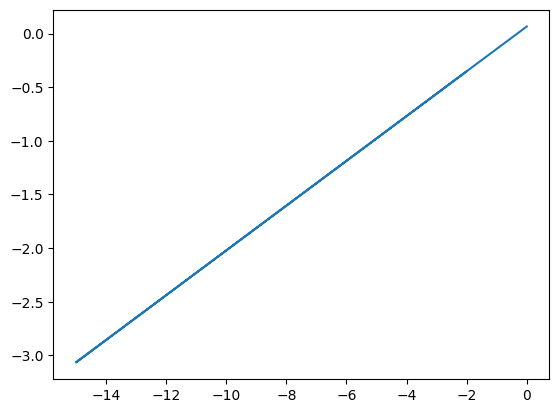

Direction is: 191.79520415236053
Road pixels for neighbour pixel (16, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2.  2.]
 [ 2.  3.]
 [ 3.  4.]
 [ 4.  5.]
 [ 5.  6.]
 [ 6.  7.]
 [ 7.  7.]
 [ 8.  7.]
 [ 9.  8.]
 [10.  8.]
 [11.  9.]
 [12.  9.]
 [13.  9.]
 [14. 10.]
 [15. 10.]
 [ 1.  1.]
 [ 0.  0.]]
Line: [0.63090677 1.64878672]


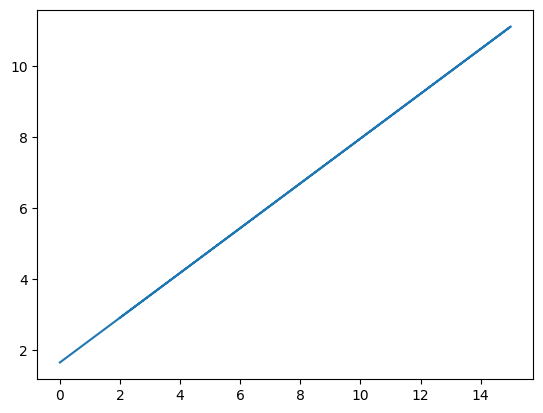

Direction is: 32.248104888910355
Road pixels for neighbour pixel (16, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  2.  -2.]
 [  2.  -3.]
 [  2.  -4.]
 [  2.  -5.]
 [  2.  -6.]
 [  3.  -7.]
 [  3.  -8.]
 [  3.  -9.]
 [  3. -10.]
 [  4. -11.]
 [  4. -12.]
 [  5. -13.]
 [  5. -14.]
 [  6. -15.]
 [  1.  -1.]
 [  0.   0.]]
Line: [-2.91032149  1.04906937]


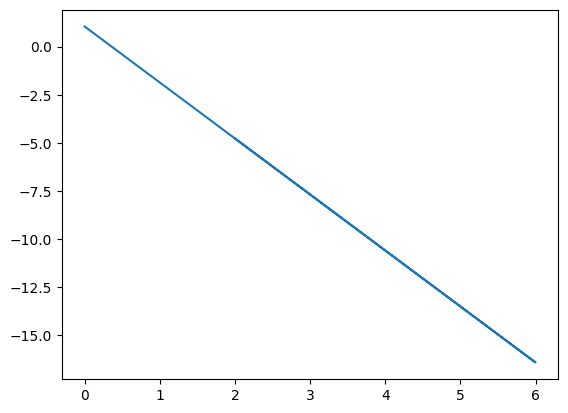

Direction is: 288.96295966442773
Sorted vector of angles: [32.248104888910355, 191.79520415236053, 288.96295966442773]
Descriptors: [[32.248104888910355, 191.79520415236053, 288.96295966442773]] for mapbox image 50.7768849_3.522932.png
Number of descriptors: 1
Descriptor of segmentation image:
[71.56505117707798, 176.38170223086667, 289.79450363229324]
Descriptor of mapbox image:
[32.248104888910355, 191.79520415236053, 288.96295966442773]
x = 71.56505117707798, y = 32.248104888910355
x = 176.38170223086667, y = 191.79520415236053
x = 289.79450363229324, y = 288.96295966442773
Result = 42.23848686069431
**************************************************
Mapbox image: 50.7764728_3.5243937.png
**************************************************
Finding descriptors in mapbox image 50.7764728_3.5243937.png
Getting intersections in skeleton (more than 2 neighbours)
2 intersections found in the skeleton
Solidity = 0.16619051458983722 -> this contour can be related to an intersection in the ro

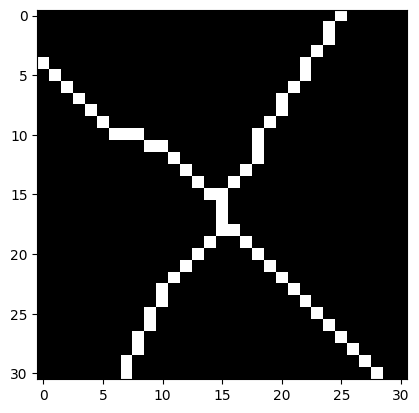

Road pixels for neighbour pixel (14, 15) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.   1.]
 [ -3.   2.]
 [ -4.   3.]
 [ -5.   4.]
 [ -6.   4.]
 [ -7.   5.]
 [ -8.   5.]
 [ -9.   5.]
 [-10.   6.]
 [-11.   7.]
 [-12.   8.]
 [-13.   9.]
 [-14.  10.]
 [-15.  11.]
 [ -1.   0.]
 [  0.   0.]]
Line: [-0.70294118 -0.27205882]


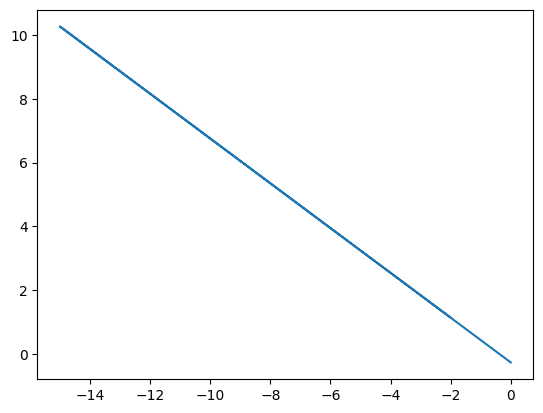

Direction is: 144.89503735061996
Road pixels for neighbour pixel (15, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  0.  -2.]
 [  0.  -3.]
 [ -1.  -4.]
 [ -2.  -5.]
 [ -3.  -6.]
 [ -4.  -7.]
 [ -5.  -8.]
 [ -5.  -9.]
 [ -6. -10.]
 [ -6. -11.]
 [ -7. -12.]
 [ -7. -13.]
 [ -8. -14.]
 [ -8. -15.]
 [  1.  -3.]
 [  2.  -4.]
 [  3.  -5.]
 [  4.  -6.]
 [  5.  -7.]
 [  6.  -8.]
 [  7.  -9.]
 [  8. -10.]
 [  9. -11.]
 [ 10. -12.]
 [ 11. -13.]
 [ 12. -14.]
 [ 13. -15.]
 [  0.  -1.]
 [  0.   0.]]
Line: [-0.07363014 -8.09878366]


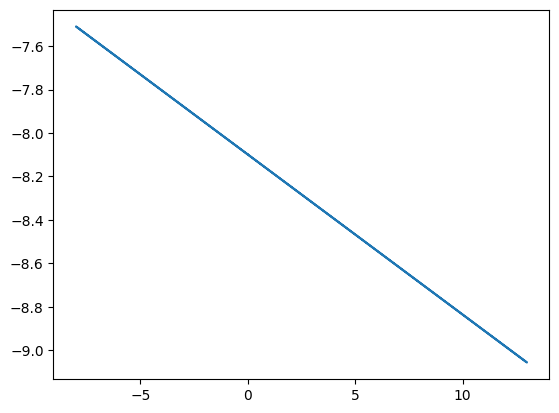

Direction is: 355.78890294476156
Road pixels for neighbour pixel (16, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2.  2.]
 [ 3.  3.]
 [ 3.  4.]
 [ 3.  5.]
 [ 4.  6.]
 [ 5.  7.]
 [ 5.  8.]
 [ 6.  9.]
 [ 7. 10.]
 [ 7. 11.]
 [ 8. 12.]
 [ 9. 13.]
 [ 9. 14.]
 [10. 15.]
 [ 1.  1.]
 [ 0.  0.]]
Line: [ 1.56079855 -0.49909256]


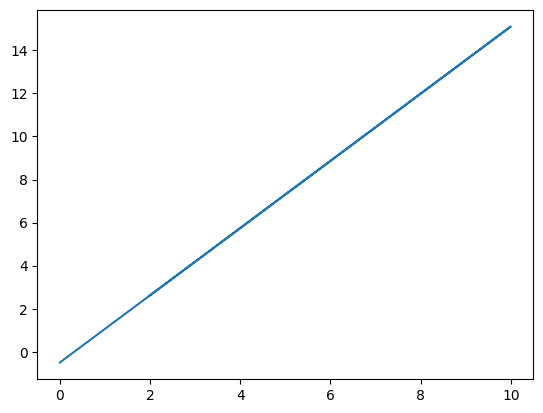

Direction is: 57.35240765375235
Sorted vector of angles: [57.35240765375235, 144.89503735061996, 355.78890294476156]


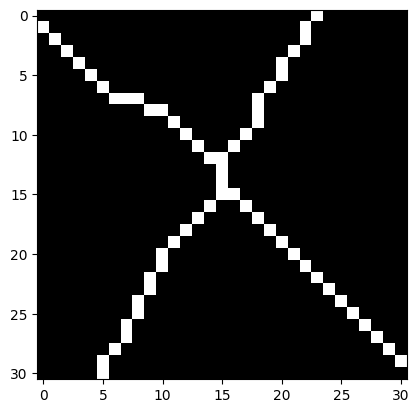

Road pixels for neighbour pixel (14, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.  -2.]
 [ -3.  -3.]
 [ -4.  -4.]
 [ -5.  -5.]
 [ -5.  -6.]
 [ -6.  -7.]
 [ -6.  -8.]
 [ -7.  -9.]
 [ -7. -10.]
 [ -8. -11.]
 [ -8. -12.]
 [ -9. -13.]
 [-10. -14.]
 [-10. -15.]
 [ -1.  -1.]
 [  0.   0.]]
Line: [1.53071144 1.20592134]


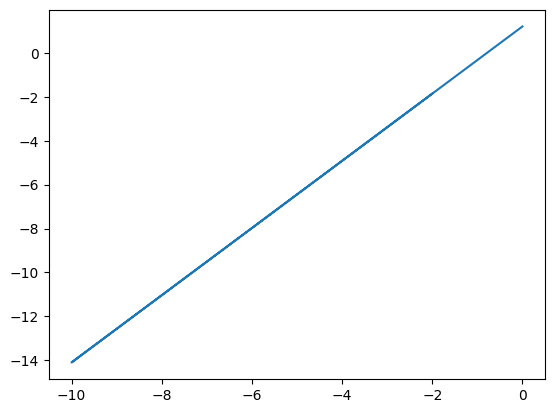

Direction is: 236.84377634645122
Road pixels for neighbour pixel (15, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  0.   2.]
 [ -1.   3.]
 [ -2.   4.]
 [ -3.   5.]
 [ -4.   6.]
 [ -5.   7.]
 [ -6.   7.]
 [ -7.   8.]
 [ -8.   8.]
 [ -9.   8.]
 [-10.   9.]
 [-11.  10.]
 [-12.  11.]
 [-13.  12.]
 [-14.  13.]
 [-15.  14.]
 [  0.   3.]
 [  1.   4.]
 [  2.   5.]
 [  3.   6.]
 [  3.   7.]
 [  3.   8.]
 [  4.   9.]
 [  5.  10.]
 [  5.  11.]
 [  6.  12.]
 [  7.  13.]
 [  7.  14.]
 [  8.  15.]
 [  0.   1.]
 [  0.   0.]]
Line: [-0.05617198  7.78363384]


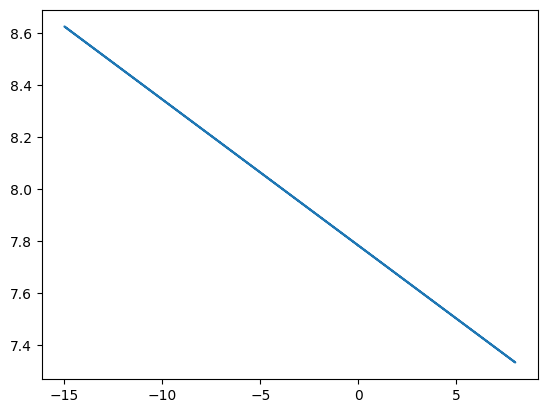

Direction is: 176.78496104821136
Road pixels for neighbour pixel (16, 15) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  2.  -1.]
 [  3.  -2.]
 [  4.  -3.]
 [  5.  -4.]
 [  6.  -5.]
 [  7.  -6.]
 [  8.  -7.]
 [  9.  -8.]
 [ 10.  -9.]
 [ 11. -10.]
 [ 12. -11.]
 [ 13. -12.]
 [ 14. -13.]
 [ 15. -14.]
 [  1.   0.]
 [  0.   0.]]
Line: [-0.97794118  0.77205882]


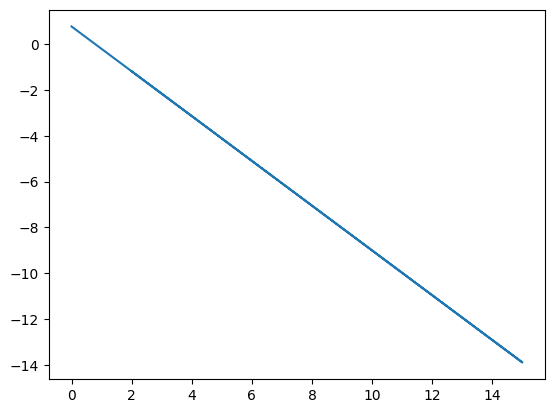

Direction is: 315.63895989899163
Sorted vector of angles: [176.78496104821136, 236.84377634645122, 315.63895989899163]
Descriptors: [[57.35240765375235, 144.89503735061996, 355.78890294476156], [176.78496104821136, 236.84377634645122, 315.63895989899163]] for mapbox image 50.7764728_3.5243937.png
Number of descriptors: 2
Descriptor of segmentation image:
[71.56505117707798, 176.38170223086667, 289.79450363229324]
Descriptor of mapbox image:
[57.35240765375235, 144.89503735061996, 355.78890294476156]
x = 71.56505117707798, y = 57.35240765375235
x = 176.38170223086667, y = 144.89503735061996
x = 289.79450363229324, y = 355.78890294476156
Result = 74.48939549906154
Descriptor of mapbox image:
[176.78496104821136, 236.84377634645122, 315.63895989899163]
x = 71.56505117707798, y = 176.78496104821136
x = 176.38170223086667, y = 236.84377634645122
x = 289.79450363229324, y = 315.63895989899163
Result = 124.07589515844388
**************************************************
Mapbox image: 50.7766

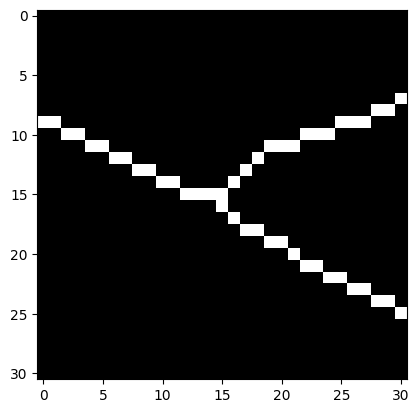

Road pixels for neighbour pixel (14, 15) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.   0.]
 [ -3.   0.]
 [ -4.   1.]
 [ -5.   1.]
 [ -6.   2.]
 [ -7.   2.]
 [ -8.   3.]
 [ -9.   3.]
 [-10.   4.]
 [-11.   4.]
 [-12.   5.]
 [-13.   5.]
 [-14.   6.]
 [-15.   6.]
 [ -1.   0.]
 [  0.   0.]]
Line: [-0.45294118 -0.77205882]


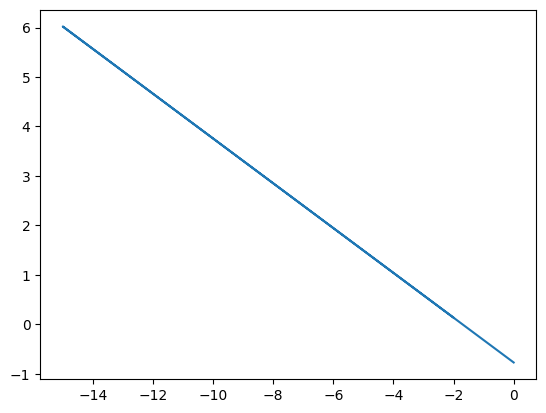

Direction is: 155.63227015844438
Road pixels for neighbour pixel (15, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  1.  -2.]
 [  2.  -3.]
 [  3.  -3.]
 [  4.  -4.]
 [  5.  -4.]
 [  6.  -5.]
 [  7.  -6.]
 [  8.  -6.]
 [  9.  -7.]
 [ 10.  -7.]
 [ 11.  -8.]
 [ 12.  -8.]
 [ 13.  -9.]
 [ 14.  -9.]
 [ 15. -10.]
 [  0.  -1.]
 [  0.   0.]]
Line: [-0.59446108 -1.21556886]


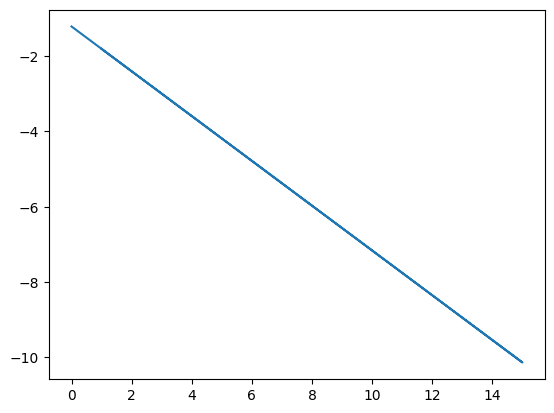

Direction is: 329.27016442474957
Road pixels for neighbour pixel (16, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2.  2.]
 [ 3.  3.]
 [ 4.  4.]
 [ 5.  4.]
 [ 6.  4.]
 [ 7.  5.]
 [ 8.  5.]
 [ 9.  5.]
 [10.  6.]
 [11.  6.]
 [12.  6.]
 [13.  7.]
 [14.  7.]
 [15.  8.]
 [ 1.  1.]
 [ 0.  0.]]
Line: [0.45147059 1.17647059]


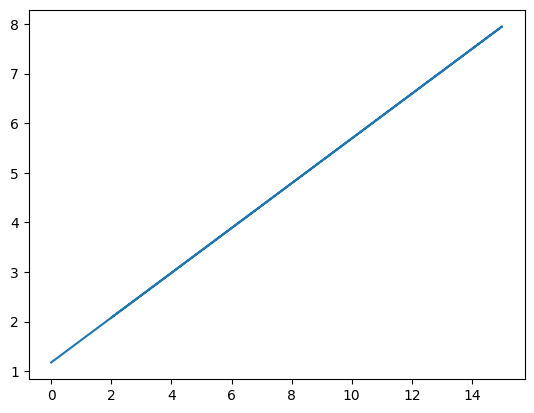

Direction is: 24.297776181464393
Sorted vector of angles: [24.297776181464393, 155.63227015844438, 329.27016442474957]


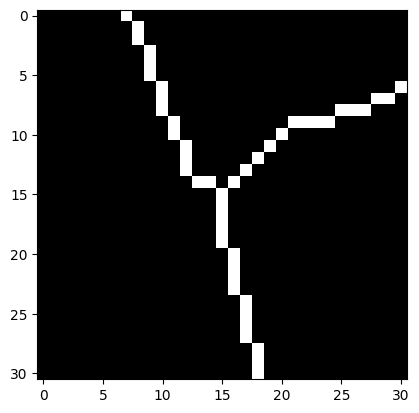

Road pixels for neighbour pixel (14, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[-2.  1.]
 [-3.  2.]
 [-3.  3.]
 [-3.  4.]
 [-4.  5.]
 [-4.  6.]
 [-5.  7.]
 [-5.  8.]
 [-5.  9.]
 [-6. 10.]
 [-6. 11.]
 [-6. 12.]
 [-7. 13.]
 [-7. 14.]
 [-8. 15.]
 [-1.  1.]
 [ 0.  0.]]
Line: [-2.14006024 -2.32379518]


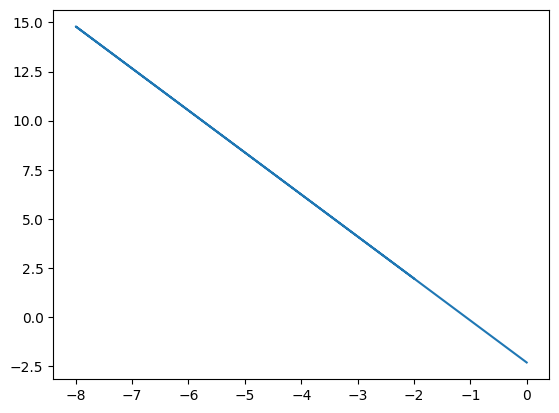

Direction is: 115.04558219170873
Road pixels for neighbour pixel (15, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  0.  -2.]
 [  0.  -3.]
 [  0.  -4.]
 [  1.  -5.]
 [  1.  -6.]
 [  1.  -7.]
 [  1.  -8.]
 [  2.  -9.]
 [  2. -10.]
 [  2. -11.]
 [  2. -12.]
 [  3. -13.]
 [  3. -14.]
 [  3. -15.]
 [  0.  -1.]
 [  0.   0.]]
Line: [-4.03858521 -2.19935691]


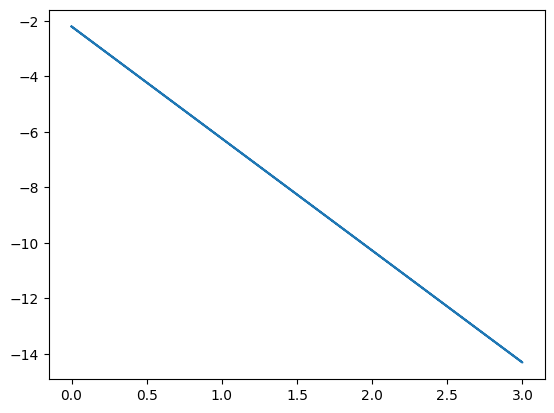

Direction is: 283.90736845487197
Road pixels for neighbour pixel (16, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2.  2.]
 [ 3.  3.]
 [ 4.  4.]
 [ 5.  5.]
 [ 6.  6.]
 [ 7.  6.]
 [ 8.  6.]
 [ 9.  6.]
 [10.  7.]
 [11.  7.]
 [12.  7.]
 [13.  8.]
 [14.  8.]
 [15.  9.]
 [ 1.  1.]
 [ 0.  0.]]
Line: [0.52794118 1.35294118]


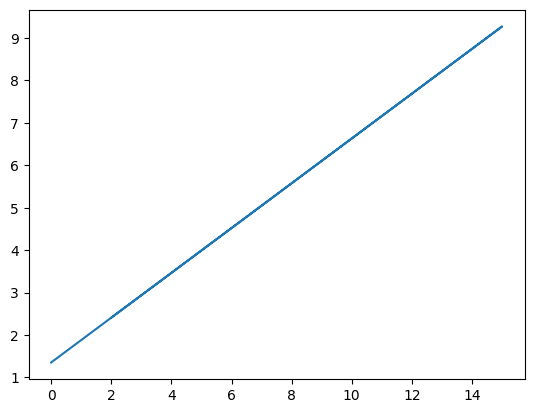

Direction is: 27.83141829463327
Sorted vector of angles: [27.83141829463327, 115.04558219170873, 283.90736845487197]
Descriptors: [[24.297776181464393, 155.63227015844438, 329.27016442474957], [27.83141829463327, 115.04558219170873, 283.90736845487197]] for mapbox image 50.7766464_3.5269705.png
Number of descriptors: 2
Descriptor of segmentation image:
[71.56505117707798, 176.38170223086667, 289.79450363229324]
Descriptor of mapbox image:
[24.297776181464393, 155.63227015844438, 329.27016442474957]
x = 71.56505117707798, y = 24.297776181464393
x = 176.38170223086667, y = 155.63227015844438
x = 289.79450363229324, y = 329.27016442474957
Result = 64.98509068886568
Descriptor of mapbox image:
[27.83141829463327, 115.04558219170873, 283.90736845487197]
x = 71.56505117707798, y = 27.83141829463327
x = 176.38170223086667, y = 115.04558219170873
x = 289.79450363229324, y = 283.90736845487197
Result = 75.56062881654488
**************************************************
Mapbox image: 50.7783431

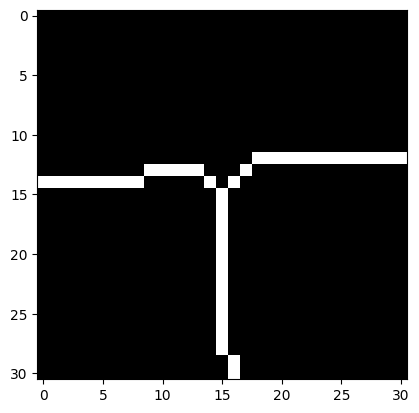

Road pixels for neighbour pixel (14, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.   2.]
 [ -3.   2.]
 [ -4.   2.]
 [ -5.   2.]
 [ -6.   2.]
 [ -7.   1.]
 [ -8.   1.]
 [ -9.   1.]
 [-10.   1.]
 [-11.   1.]
 [-12.   1.]
 [-13.   1.]
 [-14.   1.]
 [-15.   1.]
 [ -1.   1.]
 [  0.   0.]]
Line: [0.02941176 1.47058824]


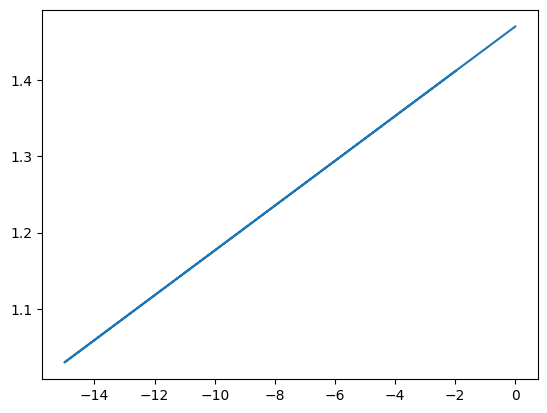

Direction is: 181.68468431789628
Road pixels for neighbour pixel (15, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  0.  -2.]
 [  0.  -3.]
 [  0.  -4.]
 [  0.  -5.]
 [  0.  -6.]
 [  0.  -7.]
 [  0.  -8.]
 [  0.  -9.]
 [  0. -10.]
 [  0. -11.]
 [  0. -12.]
 [  0. -13.]
 [  1. -14.]
 [  1. -15.]
 [  0.  -1.]
 [  0.   0.]]
Line: [-8.  -6.5]


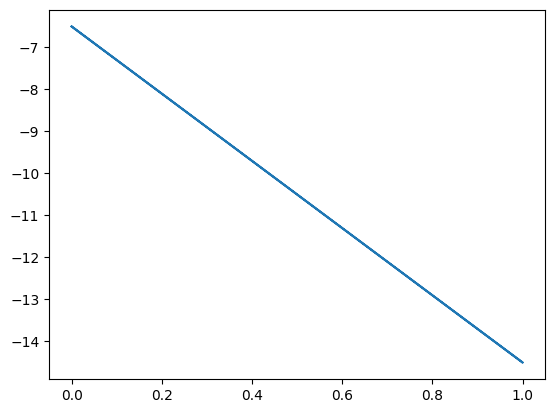

Direction is: 277.1250163489018
Road pixels for neighbour pixel (16, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2.  2.]
 [ 3.  3.]
 [ 4.  3.]
 [ 5.  3.]
 [ 6.  3.]
 [ 7.  3.]
 [ 8.  3.]
 [ 9.  3.]
 [10.  3.]
 [11.  3.]
 [12.  3.]
 [13.  3.]
 [14.  3.]
 [15.  3.]
 [ 1.  1.]
 [ 0.  0.]]
Line: [0.12058824 1.72058824]


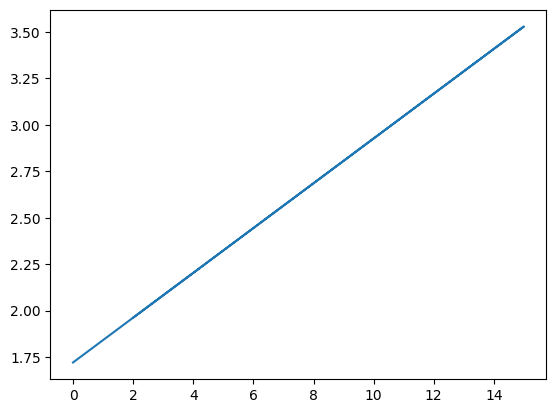

Direction is: 6.875996057355376
Sorted vector of angles: [6.875996057355376, 181.68468431789628, 277.1250163489018]
Descriptors: [[6.875996057355376, 181.68468431789628, 277.1250163489018]] for mapbox image 50.7766588_3.523478.png
Number of descriptors: 1
Descriptor of segmentation image:
[71.56505117707798, 176.38170223086667, 289.79450363229324]
Descriptor of mapbox image:
[6.875996057355376, 181.68468431789628, 277.1250163489018]
x = 71.56505117707798, y = 6.875996057355376
x = 176.38170223086667, y = 181.68468431789628
x = 289.79450363229324, y = 277.1250163489018
Result = 66.13101677217645
**************************************************
Mapbox image: 50.7773998_3.5252192.png
**************************************************
Finding descriptors in mapbox image 50.7773998_3.5252192.png
Getting intersections in skeleton (more than 2 neighbours)
1 intersections found in the skeleton
Solidity = 0.22388137519682166 -> this contour can be related to an intersection in the road
Inters

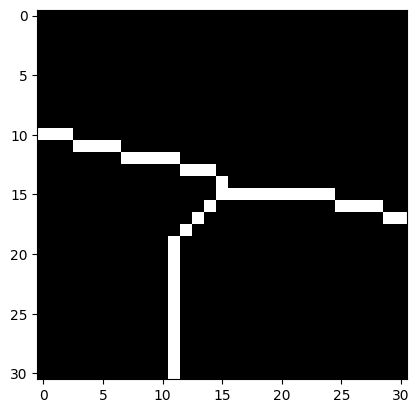

Road pixels for neighbour pixel (14, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.  -2.]
 [ -3.  -3.]
 [ -4.  -4.]
 [ -4.  -5.]
 [ -4.  -6.]
 [ -4.  -7.]
 [ -4.  -8.]
 [ -4.  -9.]
 [ -4. -10.]
 [ -4. -11.]
 [ -4. -12.]
 [ -4. -13.]
 [ -4. -14.]
 [ -4. -15.]
 [ -1.  -1.]
 [  0.   0.]]
Line: [2.73684211 1.73684211]


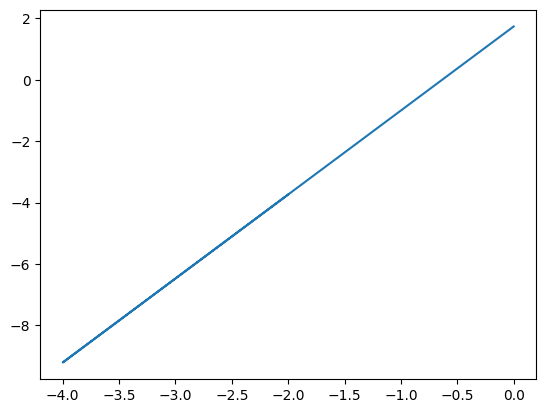

Direction is: 249.92847413546127
Road pixels for neighbour pixel (15, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -1.   2.]
 [ -2.   2.]
 [ -3.   2.]
 [ -4.   3.]
 [ -5.   3.]
 [ -6.   3.]
 [ -7.   3.]
 [ -8.   3.]
 [ -9.   4.]
 [-10.   4.]
 [-11.   4.]
 [-12.   4.]
 [-13.   5.]
 [-14.   5.]
 [-15.   5.]
 [  0.   1.]
 [  0.   0.]]
Line: [-0.26946108  1.21556886]


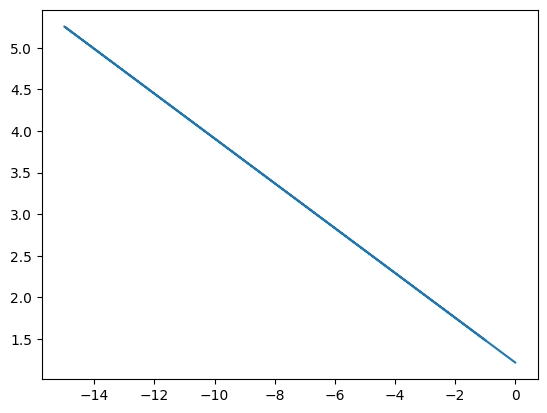

Direction is: 164.91920868855752
Road pixels for neighbour pixel (16, 15) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2.  0.]
 [ 3.  0.]
 [ 4.  0.]
 [ 5.  0.]
 [ 6.  0.]
 [ 7.  0.]
 [ 8.  0.]
 [ 9.  0.]
 [10. -1.]
 [11. -1.]
 [12. -1.]
 [13. -1.]
 [14. -2.]
 [15. -2.]
 [ 1.  0.]
 [ 0.  0.]]
Line: [-0.12941176  0.47058824]


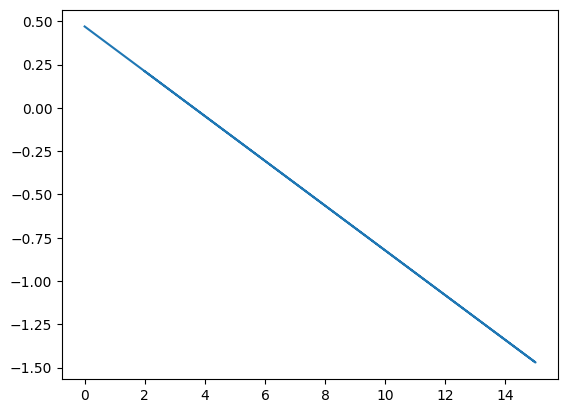

Direction is: 352.62623363866976
Sorted vector of angles: [164.91920868855752, 249.92847413546127, 352.62623363866976]
Descriptors: [[164.91920868855752, 249.92847413546127, 352.62623363866976]] for mapbox image 50.7773998_3.5252192.png
Number of descriptors: 1
Descriptor of segmentation image:
[71.56505117707798, 176.38170223086667, 289.79450363229324]
Descriptor of mapbox image:
[164.91920868855752, 249.92847413546127, 352.62623363866976]
x = 71.56505117707798, y = 164.91920868855752
x = 176.38170223086667, y = 249.92847413546127
x = 289.79450363229324, y = 352.62623363866976
Result = 134.4319630067894
**************************************************
Mapbox image: 50.7786715_3.5252944.png
**************************************************
Finding descriptors in mapbox image 50.7786715_3.5252944.png
Getting intersections in skeleton (more than 2 neighbours)
2 intersections found in the skeleton
Solidity = 0.09933925909027953 -> this contour can be related to an intersection in the r

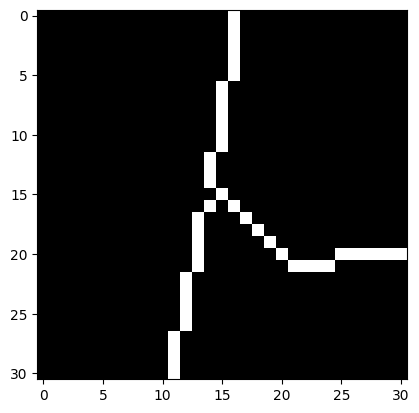

Road pixels for neighbour pixel (14, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[-1.  2.]
 [-1.  3.]
 [ 0.  4.]
 [ 0.  5.]
 [ 0.  6.]
 [ 0.  7.]
 [ 0.  8.]
 [ 0.  9.]
 [ 1. 10.]
 [ 1. 11.]
 [ 1. 12.]
 [ 1. 13.]
 [ 1. 14.]
 [ 1. 15.]
 [-1.  1.]
 [ 0.  0.]]
Line: [5.51111111 6.46666667]


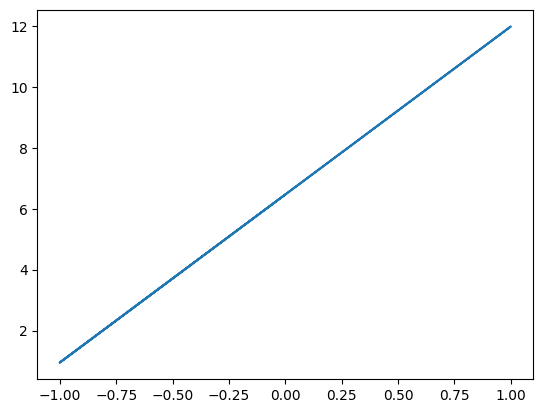

Direction is: 259.71548560259953
Road pixels for neighbour pixel (14, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.  -2.]
 [ -2.  -3.]
 [ -2.  -4.]
 [ -2.  -5.]
 [ -2.  -6.]
 [ -3.  -7.]
 [ -3.  -8.]
 [ -3.  -9.]
 [ -3. -10.]
 [ -3. -11.]
 [ -4. -12.]
 [ -4. -13.]
 [ -4. -14.]
 [ -4. -15.]
 [ -1.  -1.]
 [  0.   0.]]
Line: [3.89873418 2.73417722]


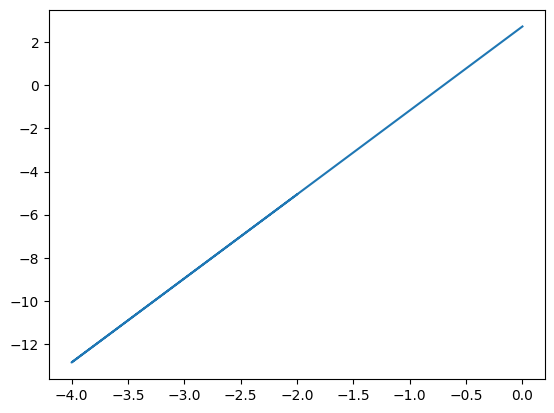

Direction is: 255.61412987544614
Road pixels for neighbour pixel (16, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2. -2.]
 [ 3. -3.]
 [ 4. -4.]
 [ 5. -5.]
 [ 6. -6.]
 [ 7. -6.]
 [ 8. -6.]
 [ 9. -6.]
 [10. -5.]
 [11. -5.]
 [12. -5.]
 [13. -5.]
 [14. -5.]
 [15. -5.]
 [ 1. -1.]
 [ 0.  0.]]
Line: [-0.27205882 -2.27205882]


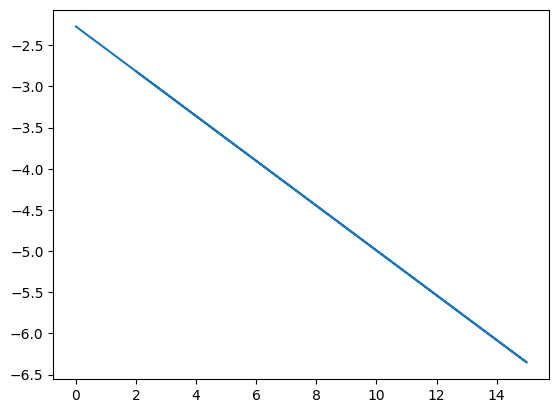

Direction is: 344.7805351688262
Sorted vector of angles: [255.61412987544614, 259.71548560259953, 344.7805351688262]


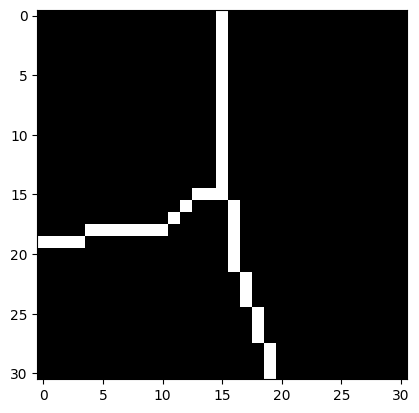

Road pixels for neighbour pixel (14, 15) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.   0.]
 [ -3.  -1.]
 [ -4.  -2.]
 [ -5.  -3.]
 [ -6.  -3.]
 [ -7.  -3.]
 [ -8.  -3.]
 [ -9.  -3.]
 [-10.  -3.]
 [-11.  -3.]
 [-12.  -4.]
 [-13.  -4.]
 [-14.  -4.]
 [-15.  -4.]
 [ -1.   0.]
 [  0.   0.]]
Line: [ 0.27941176 -0.40441176]


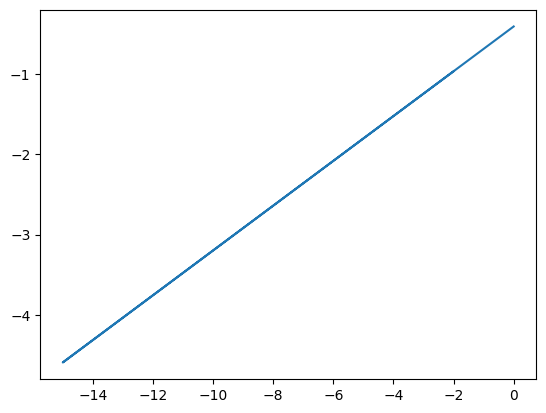

Direction is: 195.61098853367966
Road pixels for neighbour pixel (15, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 0.  2.]
 [ 0.  3.]
 [ 0.  4.]
 [ 0.  5.]
 [ 0.  6.]
 [ 0.  7.]
 [ 0.  8.]
 [ 0.  9.]
 [ 0. 10.]
 [ 0. 11.]
 [ 0. 12.]
 [ 0. 13.]
 [ 0. 14.]
 [ 0. 15.]
 [ 0.  1.]
 [ 0.  0.]]
Road pixels for neighbour pixel (16, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  1.  -2.]
 [  1.  -3.]
 [  1.  -4.]
 [  1.  -5.]
 [  1.  -6.]
 [  2.  -7.]
 [  2.  -8.]
 [  2.  -9.]
 [  3. -10.]
 [  3. -11.]
 [  3. -12.]
 [  4. -13.]
 [  4. -14.]
 [  4. -15.]
 [  1.  -1.]
 [  0.   0.]]
Line: [-3.54887218 -0.18045113]


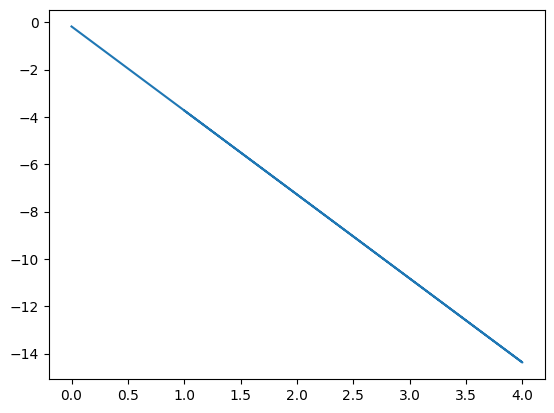

Direction is: 285.7367567296541
Sorted vector of angles: [90, 195.61098853367966, 285.7367567296541]
Descriptors: [[255.61412987544614, 259.71548560259953, 344.7805351688262], [90, 195.61098853367966, 285.7367567296541]] for mapbox image 50.7786715_3.5252944.png
Number of descriptors: 2
Descriptor of segmentation image:
[71.56505117707798, 176.38170223086667, 289.79450363229324]
Descriptor of mapbox image:
[255.61412987544614, 259.71548560259953, 344.7805351688262]
x = 71.56505117707798, y = 255.61412987544614
x = 176.38170223086667, y = 259.71548560259953
x = 289.79450363229324, y = 344.7805351688262
Result = 209.3849242063564
Descriptor of mapbox image:
[90, 195.61098853367966, 285.7367567296541]
x = 71.56505117707798, y = 90
x = 176.38170223086667, y = 195.61098853367966
x = 289.79450363229324, y = 285.7367567296541
Result = 26.945836408343002
**************************************************
Mapbox image: 50.7773096_3.5252422.png
**************************************************


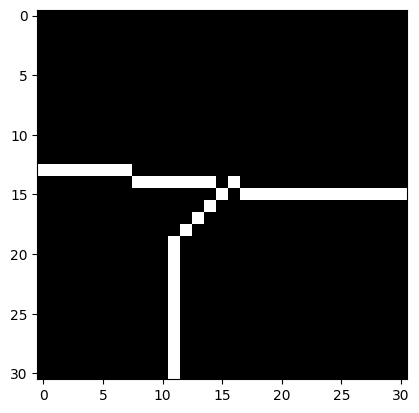

Road pixels for neighbour pixel (14, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.   1.]
 [ -3.   1.]
 [ -4.   1.]
 [ -5.   1.]
 [ -6.   1.]
 [ -7.   1.]
 [ -8.   2.]
 [ -9.   2.]
 [-10.   2.]
 [-11.   2.]
 [-12.   2.]
 [-13.   2.]
 [-14.   2.]
 [-15.   2.]
 [ -1.   1.]
 [  0.   0.]]
Line: [-0.11617647  0.56617647]


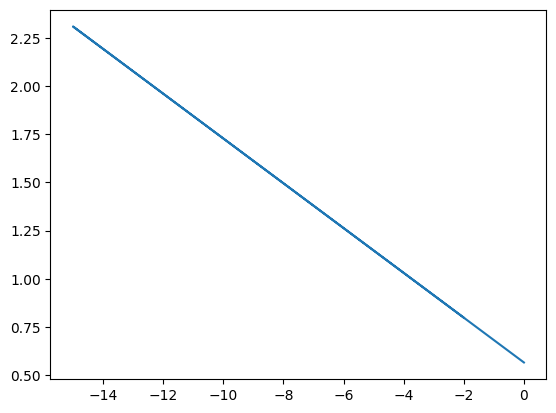

Direction is: 173.3732855312409
Road pixels for neighbour pixel (14, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.  -2.]
 [ -3.  -3.]
 [ -4.  -4.]
 [ -4.  -5.]
 [ -4.  -6.]
 [ -4.  -7.]
 [ -4.  -8.]
 [ -4.  -9.]
 [ -4. -10.]
 [ -4. -11.]
 [ -4. -12.]
 [ -4. -13.]
 [ -4. -14.]
 [ -4. -15.]
 [ -1.  -1.]
 [  0.   0.]]
Line: [2.73684211 1.73684211]


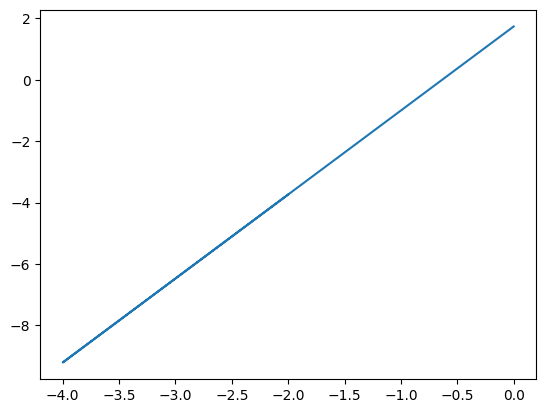

Direction is: 249.92847413546127
Road pixels for neighbour pixel (16, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2.  0.]
 [ 3.  0.]
 [ 4.  0.]
 [ 5.  0.]
 [ 6.  0.]
 [ 7.  0.]
 [ 8.  0.]
 [ 9.  0.]
 [10.  0.]
 [11.  0.]
 [12.  0.]
 [13.  0.]
 [14.  0.]
 [15.  0.]
 [ 1.  1.]
 [ 0.  0.]]
Line: [-0.01911765  0.20588235]


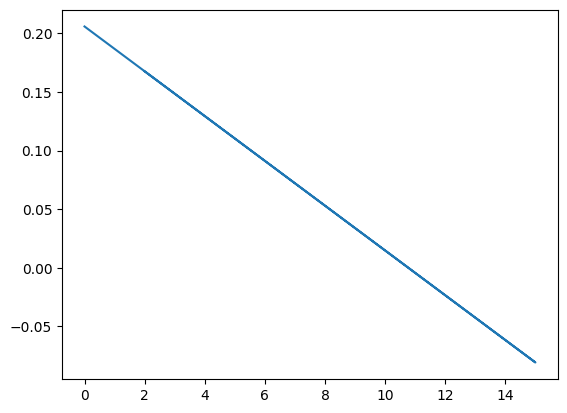

Direction is: 358.9047729257875
Sorted vector of angles: [173.3732855312409, 249.92847413546127, 358.9047729257875]
Descriptors: [[173.3732855312409, 249.92847413546127, 358.9047729257875]] for mapbox image 50.7773096_3.5252422.png
Number of descriptors: 1
Descriptor of segmentation image:
[71.56505117707798, 176.38170223086667, 289.79450363229324]
Descriptor of mapbox image:
[173.3732855312409, 249.92847413546127, 358.9047729257875]
x = 71.56505117707798, y = 173.3732855312409
x = 176.38170223086667, y = 249.92847413546127
x = 289.79450363229324, y = 358.9047729257875
Result = 143.35366602120058
**************************************************
Mapbox image: 50.7766774_3.5255084.png
**************************************************
Finding descriptors in mapbox image 50.7766774_3.5255084.png
Getting intersections in skeleton (more than 2 neighbours)
2 intersections found in the skeleton
Solidity = 0.11550838981437554 -> this contour can be related to an intersection in the road
Inte

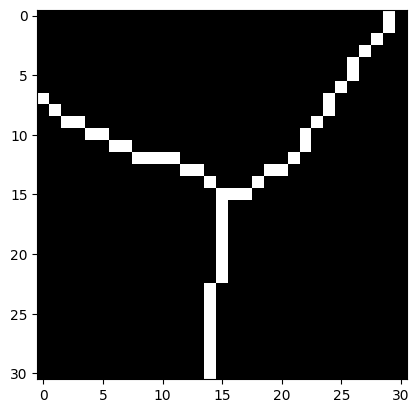

Road pixels for neighbour pixel (14, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.   2.]
 [ -3.   2.]
 [ -4.   3.]
 [ -5.   3.]
 [ -6.   3.]
 [ -7.   3.]
 [ -8.   4.]
 [ -9.   4.]
 [-10.   5.]
 [-11.   5.]
 [-12.   6.]
 [-13.   6.]
 [-14.   7.]
 [-15.   8.]
 [ -1.   1.]
 [  0.   0.]]
Line: [-0.45  0.5 ]


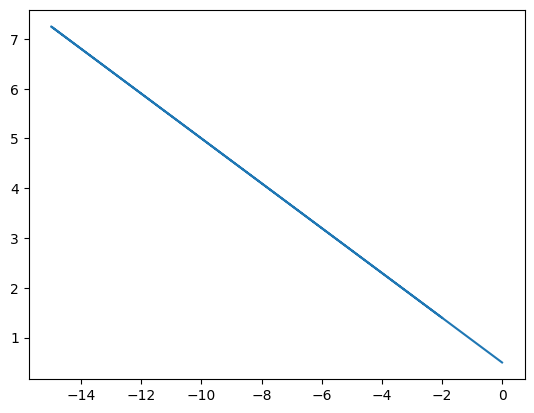

Direction is: 155.77225468204583
Road pixels for neighbour pixel (15, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  0.  -2.]
 [  0.  -3.]
 [  0.  -4.]
 [  0.  -5.]
 [  0.  -6.]
 [  0.  -7.]
 [ -1.  -8.]
 [ -1.  -9.]
 [ -1. -10.]
 [ -1. -11.]
 [ -1. -12.]
 [ -1. -13.]
 [ -1. -14.]
 [ -1. -15.]
 [  0.  -1.]
 [  0.   0.]]
Line: [ 8.  -3.5]


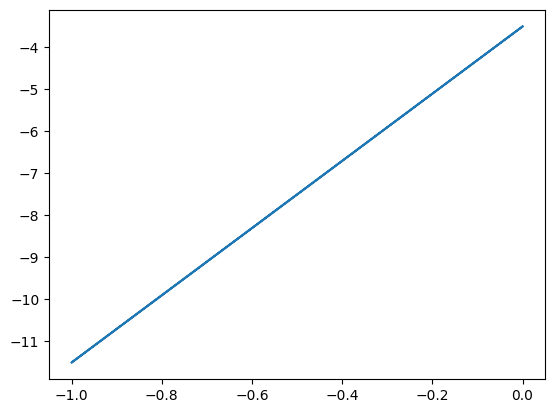

Direction is: 262.8749836510982
Road pixels for neighbour pixel (16, 15) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2.  0.]
 [ 3.  1.]
 [ 4.  2.]
 [ 5.  2.]
 [ 6.  3.]
 [ 7.  4.]
 [ 7.  5.]
 [ 8.  6.]
 [ 9.  7.]
 [ 9.  8.]
 [10.  9.]
 [11. 10.]
 [11. 11.]
 [12. 12.]
 [13. 13.]
 [14. 14.]
 [14. 15.]
 [ 1.  0.]
 [ 0.  0.]]
Line: [ 1.13943052 -2.33457134]


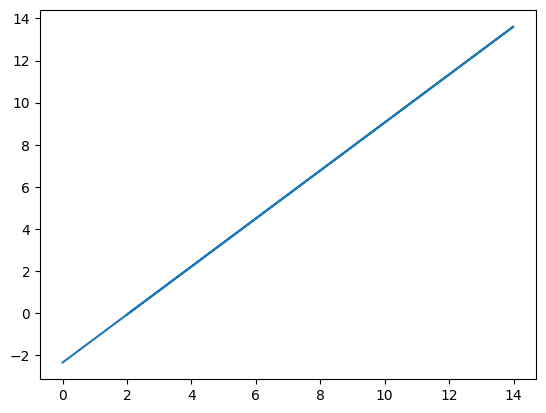

Direction is: 48.72879530840704
Sorted vector of angles: [48.72879530840704, 155.77225468204583, 262.8749836510982]


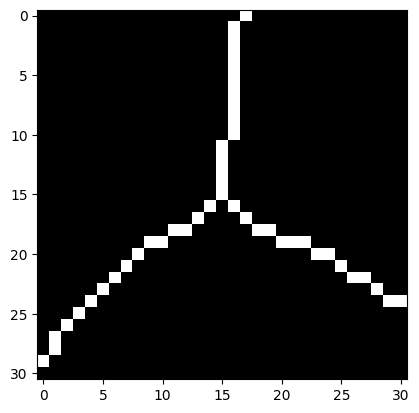

Road pixels for neighbour pixel (14, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.  -2.]
 [ -3.  -3.]
 [ -4.  -3.]
 [ -5.  -4.]
 [ -6.  -4.]
 [ -7.  -5.]
 [ -8.  -6.]
 [ -9.  -7.]
 [-10.  -8.]
 [-11.  -9.]
 [-12. -10.]
 [-13. -11.]
 [-14. -12.]
 [-14. -13.]
 [-15. -14.]
 [ -1.  -1.]
 [  0.   0.]]
Line: [0.88258984 0.36864932]


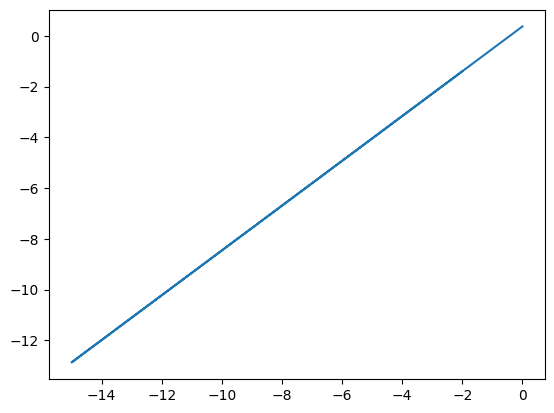

Direction is: 221.43129637491063
Road pixels for neighbour pixel (15, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 0.  2.]
 [ 0.  3.]
 [ 0.  4.]
 [ 1.  5.]
 [ 1.  6.]
 [ 1.  7.]
 [ 1.  8.]
 [ 1.  9.]
 [ 1. 10.]
 [ 1. 11.]
 [ 1. 12.]
 [ 1. 13.]
 [ 1. 14.]
 [ 2. 15.]
 [ 0.  1.]
 [ 0.  0.]]
Line: [7.   2.25]


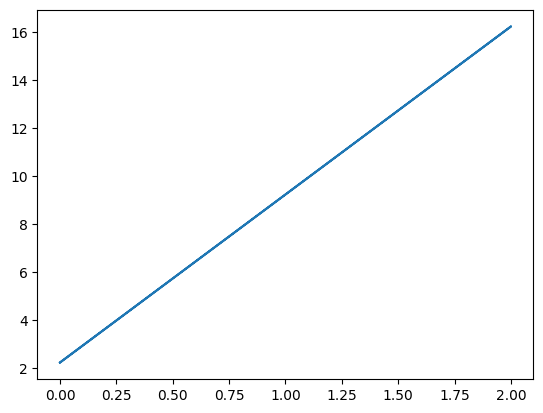

Direction is: 81.86989764584403
Road pixels for neighbour pixel (16, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2. -2.]
 [ 3. -3.]
 [ 4. -3.]
 [ 5. -4.]
 [ 6. -4.]
 [ 7. -4.]
 [ 8. -5.]
 [ 9. -5.]
 [10. -6.]
 [11. -7.]
 [12. -7.]
 [13. -8.]
 [14. -9.]
 [15. -9.]
 [ 1. -1.]
 [ 0.  0.]]
Line: [-0.56323529 -0.58823529]


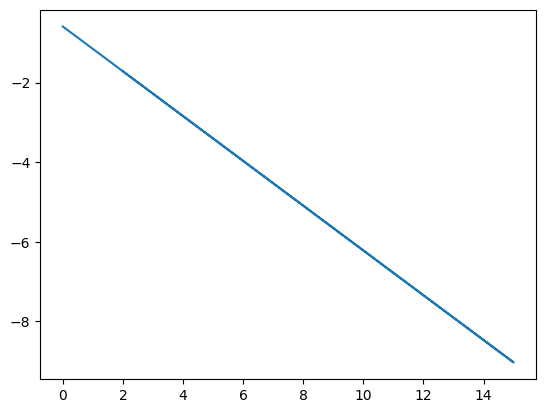

Direction is: 330.6102532842859
Sorted vector of angles: [81.86989764584403, 221.43129637491063, 330.6102532842859]
Descriptors: [[48.72879530840704, 155.77225468204583, 262.8749836510982], [81.86989764584403, 221.43129637491063, 330.6102532842859]] for mapbox image 50.7766774_3.5255084.png
Number of descriptors: 2
Descriptor of segmentation image:
[71.56505117707798, 176.38170223086667, 289.79450363229324]
Descriptor of mapbox image:
[48.72879530840704, 155.77225468204583, 262.8749836510982]
x = 71.56505117707798, y = 48.72879530840704
x = 176.38170223086667, y = 155.77225468204583
x = 289.79450363229324, y = 262.8749836510982
Result = 40.876698330283034
Descriptor of mapbox image:
[81.86989764584403, 221.43129637491063, 330.6102532842859]
x = 71.56505117707798, y = 81.86989764584403
x = 176.38170223086667, y = 221.43129637491063
x = 289.79450363229324, y = 330.6102532842859
Result = 61.65696402631302
**************************************************
Mapbox image: 50.7777499_3.522467

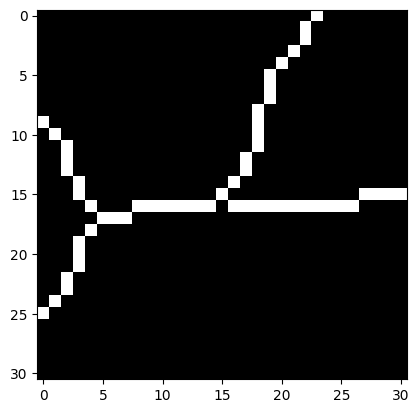

Road pixels for neighbour pixel (14, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.  -1.]
 [ -3.  -1.]
 [ -4.  -1.]
 [ -5.  -1.]
 [ -6.  -1.]
 [ -7.  -1.]
 [ -8.  -2.]
 [ -9.  -2.]
 [-10.  -2.]
 [-11.  -1.]
 [-12.   0.]
 [-12.   1.]
 [-13.   2.]
 [-13.   3.]
 [-13.   4.]
 [-14.   5.]
 [-15.   6.]
 [-11.  -3.]
 [-12.  -4.]
 [-12.  -5.]
 [-12.  -6.]
 [-13.  -7.]
 [-13.  -8.]
 [-14.  -9.]
 [-15. -10.]
 [ -1.  -1.]
 [  0.   0.]]
Line: [ 0.10308702 -0.67397681]


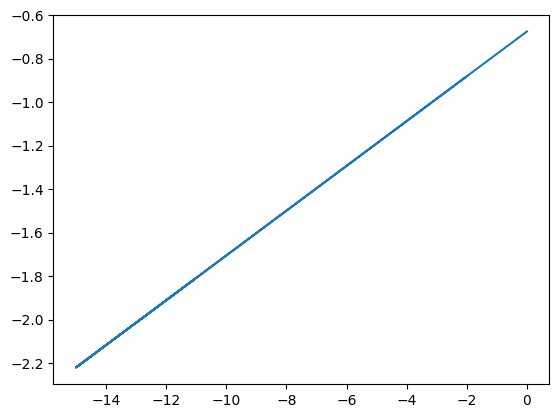

Direction is: 185.88566126970773
Road pixels for neighbour pixel (16, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2.  2.]
 [ 2.  3.]
 [ 3.  4.]
 [ 3.  5.]
 [ 3.  6.]
 [ 3.  7.]
 [ 4.  8.]
 [ 4.  9.]
 [ 4. 10.]
 [ 5. 11.]
 [ 6. 12.]
 [ 7. 13.]
 [ 7. 14.]
 [ 8. 15.]
 [ 1.  1.]
 [ 0.  0.]]
Line: [ 2.05940594 -0.48019802]


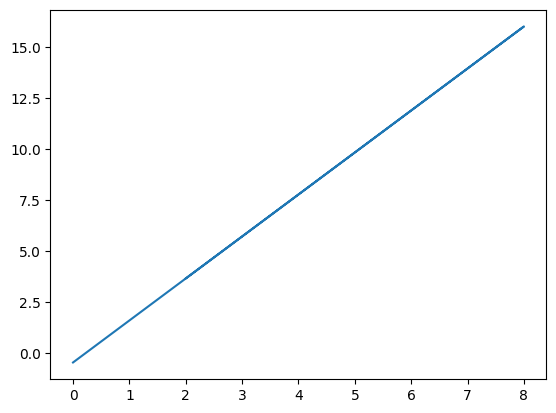

Direction is: 64.09986032095655
Road pixels for neighbour pixel (16, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2. -1.]
 [ 3. -1.]
 [ 4. -1.]
 [ 5. -1.]
 [ 6. -1.]
 [ 7. -1.]
 [ 8. -1.]
 [ 9. -1.]
 [10. -1.]
 [11. -1.]
 [12.  0.]
 [13.  0.]
 [14.  0.]
 [15.  0.]
 [ 1. -1.]
 [ 0.  0.]]
Line: [ 0.04852941 -1.05147059]


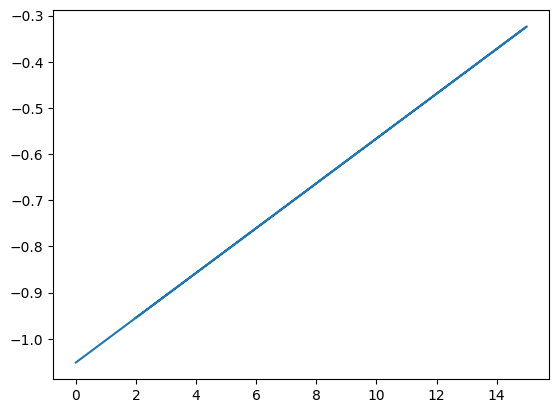

Direction is: 2.778350743005073
Sorted vector of angles: [2.778350743005073, 64.09986032095655, 185.88566126970773]


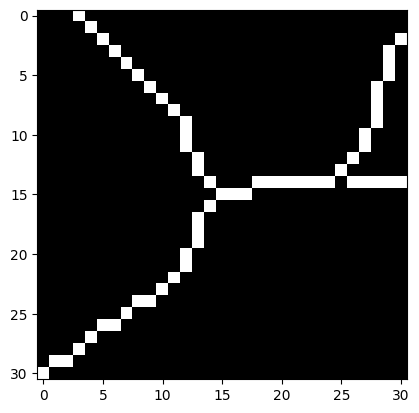

Road pixels for neighbour pixel (14, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.   2.]
 [ -2.   3.]
 [ -3.   4.]
 [ -3.   5.]
 [ -3.   6.]
 [ -4.   7.]
 [ -5.   8.]
 [ -6.   9.]
 [ -7.  10.]
 [ -8.  11.]
 [ -9.  12.]
 [-10.  13.]
 [-11.  14.]
 [-12.  15.]
 [ -1.   1.]
 [  0.   0.]]
Line: [-1.25387366  0.76042908]


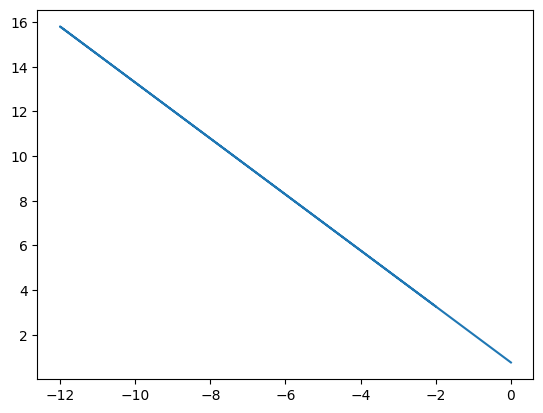

Direction is: 128.57335925589516
Road pixels for neighbour pixel (14, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.  -2.]
 [ -2.  -3.]
 [ -2.  -4.]
 [ -3.  -5.]
 [ -3.  -6.]
 [ -4.  -7.]
 [ -5.  -8.]
 [ -6.  -9.]
 [ -7.  -9.]
 [ -8. -10.]
 [ -9. -11.]
 [-10. -11.]
 [-11. -12.]
 [-12. -13.]
 [-13. -14.]
 [-14. -14.]
 [-15. -15.]
 [ -1.  -1.]
 [  0.   0.]]
Line: [ 0.94983234 -1.7563838 ]


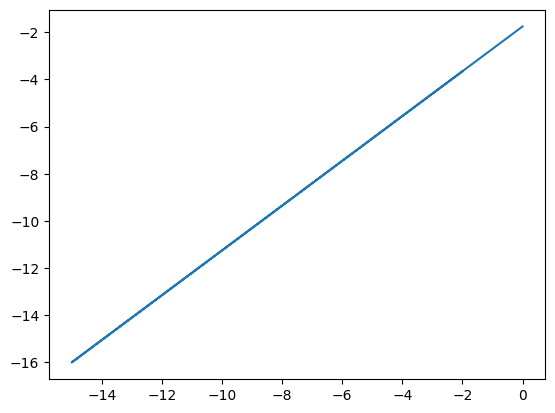

Direction is: 223.52614974486715
Road pixels for neighbour pixel (16, 15) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2.  0.]
 [ 3.  1.]
 [ 4.  1.]
 [ 5.  1.]
 [ 6.  1.]
 [ 7.  1.]
 [ 8.  1.]
 [ 9.  1.]
 [10.  2.]
 [11.  3.]
 [12.  4.]
 [12.  5.]
 [13.  6.]
 [13.  7.]
 [13.  8.]
 [13.  9.]
 [14. 10.]
 [14. 11.]
 [14. 12.]
 [15. 13.]
 [11.  1.]
 [12.  1.]
 [13.  1.]
 [14.  1.]
 [15.  1.]
 [ 1.  0.]
 [ 0.  0.]]
Line: [ 0.57065868 -1.80199601]


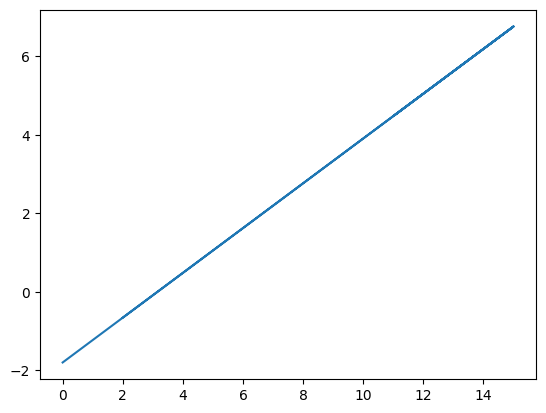

Direction is: 29.71161707570102
Sorted vector of angles: [29.71161707570102, 128.57335925589516, 223.52614974486715]
Descriptors: [[2.778350743005073, 64.09986032095655, 185.88566126970773], [29.71161707570102, 128.57335925589516, 223.52614974486715]] for mapbox image 50.7777499_3.5224676.png
Number of descriptors: 2
Descriptor of segmentation image:
[71.56505117707798, 176.38170223086667, 289.79450363229324]
Descriptor of mapbox image:
[2.778350743005073, 64.09986032095655, 185.88566126970773]
x = 71.56505117707798, y = 2.778350743005073
x = 176.38170223086667, y = 64.09986032095655
x = 289.79450363229324, y = 185.88566126970773
Result = 167.73750236730478
Descriptor of mapbox image:
[29.71161707570102, 128.57335925589516, 223.52614974486715]
x = 71.56505117707798, y = 29.71161707570102
x = 176.38170223086667, y = 128.57335925589516
x = 289.79450363229324, y = 223.52614974486715
Result = 91.80872687843978
**************************************************
Mapbox image: 50.7753884_3.52

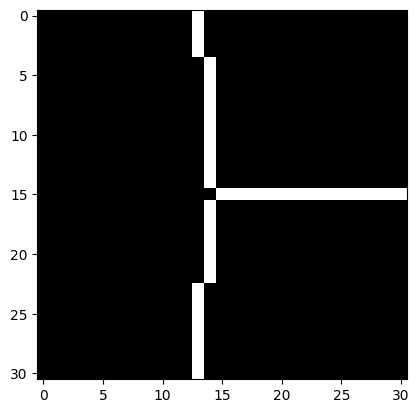

Road pixels for neighbour pixel (14, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[-1.  2.]
 [-1.  3.]
 [-1.  4.]
 [-1.  5.]
 [-1.  6.]
 [-1.  7.]
 [-1.  8.]
 [-1.  9.]
 [-1. 10.]
 [-1. 11.]
 [-2. 12.]
 [-2. 13.]
 [-2. 14.]
 [-2. 15.]
 [-1.  1.]
 [ 0.  0.]]
Line: [-7.09859155 -0.92957746]


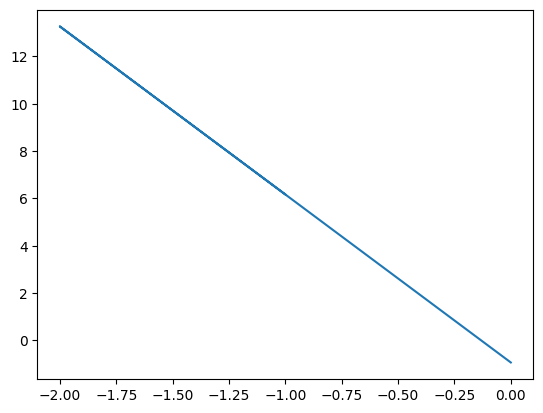

Direction is: 98.01866307912194
Road pixels for neighbour pixel (14, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -1.  -2.]
 [ -1.  -3.]
 [ -1.  -4.]
 [ -1.  -5.]
 [ -1.  -6.]
 [ -1.  -7.]
 [ -2.  -8.]
 [ -2.  -9.]
 [ -2. -10.]
 [ -2. -11.]
 [ -2. -12.]
 [ -2. -13.]
 [ -2. -14.]
 [ -2. -15.]
 [ -1.  -1.]
 [  0.   0.]]
Line: [6.65263158 2.06315789]


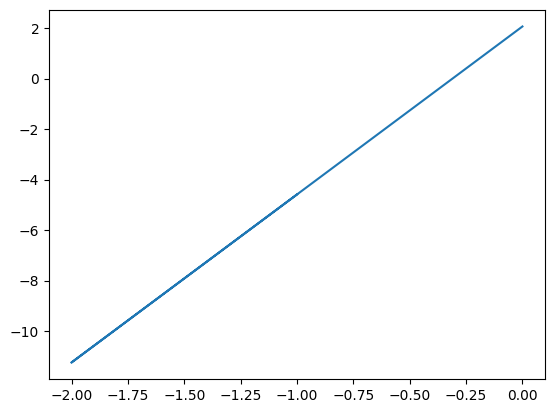

Direction is: 261.4515026213296
Road pixels for neighbour pixel (16, 15) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2.  0.]
 [ 3.  0.]
 [ 4.  0.]
 [ 5.  0.]
 [ 6.  0.]
 [ 7.  0.]
 [ 8.  0.]
 [ 9.  0.]
 [10.  0.]
 [11.  0.]
 [12.  0.]
 [13.  0.]
 [14.  0.]
 [15.  0.]
 [ 1.  0.]
 [ 0.  0.]]
Line: [0. 0.]


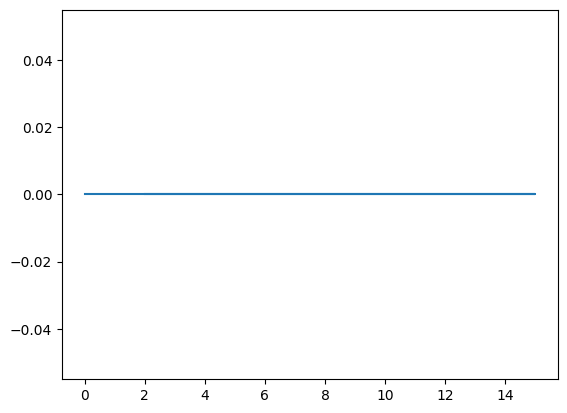

Direction is: 360.0
Sorted vector of angles: [98.01866307912194, 261.4515026213296, 360.0]


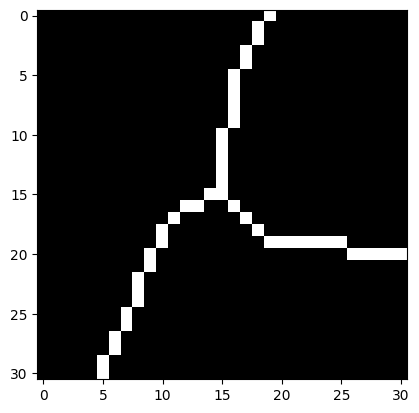

Road pixels for neighbour pixel (14, 15) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.  -1.]
 [ -3.  -1.]
 [ -4.  -2.]
 [ -5.  -3.]
 [ -5.  -4.]
 [ -6.  -5.]
 [ -6.  -6.]
 [ -7.  -7.]
 [ -7.  -8.]
 [ -7.  -9.]
 [ -8. -10.]
 [ -8. -11.]
 [ -9. -12.]
 [ -9. -13.]
 [-10. -14.]
 [-10. -15.]
 [ -1.   0.]
 [  0.   0.]]
Line: [1.60661097 2.82818743]


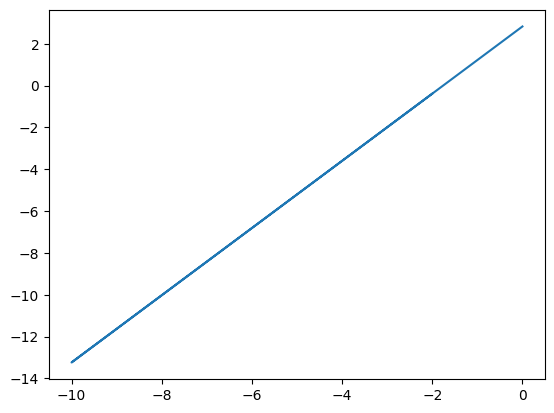

Direction is: 238.10070053680982
Road pixels for neighbour pixel (15, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 0.  2.]
 [ 0.  3.]
 [ 0.  4.]
 [ 0.  5.]
 [ 1.  6.]
 [ 1.  7.]
 [ 1.  8.]
 [ 1.  9.]
 [ 1. 10.]
 [ 2. 11.]
 [ 2. 12.]
 [ 3. 13.]
 [ 3. 14.]
 [ 4. 15.]
 [ 0.  1.]
 [ 0.  0.]]
Line: [3.45780051 3.39386189]


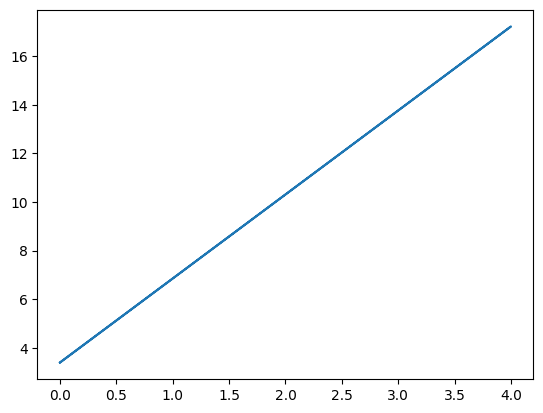

Direction is: 73.87006826205496
Road pixels for neighbour pixel (16, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2. -2.]
 [ 3. -3.]
 [ 4. -4.]
 [ 5. -4.]
 [ 6. -4.]
 [ 7. -4.]
 [ 8. -4.]
 [ 9. -4.]
 [10. -4.]
 [11. -5.]
 [12. -5.]
 [13. -5.]
 [14. -5.]
 [15. -5.]
 [ 1. -1.]
 [ 0.  0.]]
Line: [-0.27205882 -1.64705882]


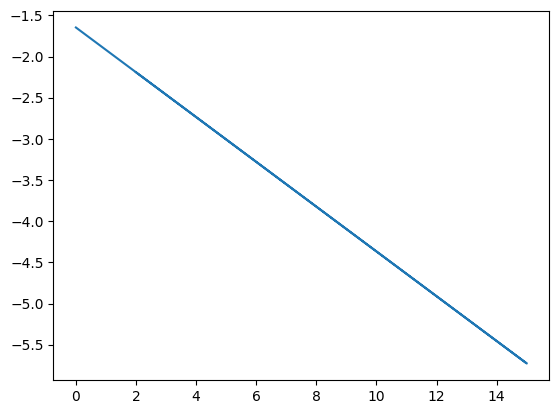

Direction is: 344.7805351688262
Sorted vector of angles: [73.87006826205496, 238.10070053680982, 344.7805351688262]
Descriptors: [[98.01866307912194, 261.4515026213296, 360.0], [73.87006826205496, 238.10070053680982, 344.7805351688262]] for mapbox image 50.7753884_3.5260338.png
Number of descriptors: 2
Descriptor of segmentation image:
[71.56505117707798, 176.38170223086667, 289.79450363229324]
Descriptor of mapbox image:
[98.01866307912194, 261.4515026213296, 360.0]
x = 71.56505117707798, y = 98.01866307912194
x = 176.38170223086667, y = 261.4515026213296
x = 289.79450363229324, y = 360.0
Result = 113.42608272074486
Descriptor of mapbox image:
[73.87006826205496, 238.10070053680982, 344.7805351688262]
x = 71.56505117707798, y = 73.87006826205496
x = 176.38170223086667, y = 238.10070053680982
x = 289.79450363229324, y = 344.7805351688262
Result = 82.69227001230313
**************************************************
Mapbox image: 50.7771172_3.5208395.png
*********************************

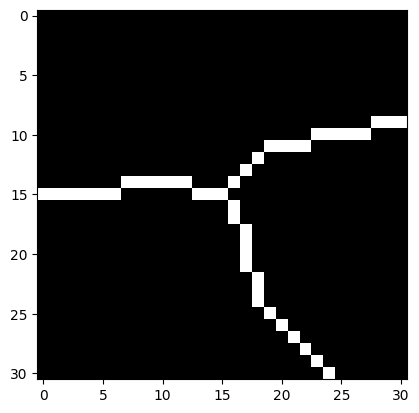

Road pixels for neighbour pixel (14, 15) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.   0.]
 [ -3.   1.]
 [ -4.   1.]
 [ -5.   1.]
 [ -6.   1.]
 [ -7.   1.]
 [ -8.   1.]
 [ -9.   0.]
 [-10.   0.]
 [-11.   0.]
 [-12.   0.]
 [-13.   0.]
 [-14.   0.]
 [-15.   0.]
 [ -1.   0.]
 [  0.   0.]]
Line: [0.03529412 0.63970588]


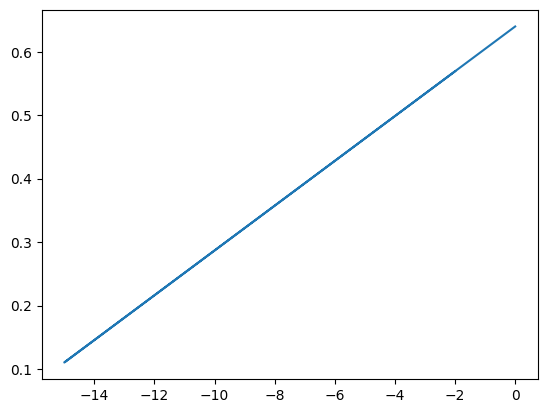

Direction is: 182.02136494035602
Road pixels for neighbour pixel (16, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2.  2.]
 [ 3.  3.]
 [ 4.  4.]
 [ 5.  4.]
 [ 6.  4.]
 [ 7.  4.]
 [ 8.  5.]
 [ 9.  5.]
 [10.  5.]
 [11.  5.]
 [12.  5.]
 [13.  6.]
 [14.  6.]
 [15.  6.]
 [ 1.  1.]
 [ 0.  0.]]
Line: [0.34264706 1.49264706]


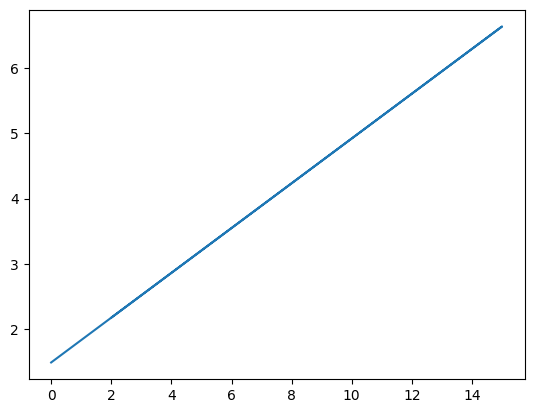

Direction is: 18.913872913036105
Road pixels for neighbour pixel (16, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  1.  -2.]
 [  2.  -3.]
 [  2.  -4.]
 [  2.  -5.]
 [  2.  -6.]
 [  3.  -7.]
 [  3.  -8.]
 [  3.  -9.]
 [  4. -10.]
 [  5. -11.]
 [  6. -12.]
 [  7. -13.]
 [  8. -14.]
 [  9. -15.]
 [  1.  -1.]
 [  0.   0.]]
Line: [-1.71158392 -1.29550827]


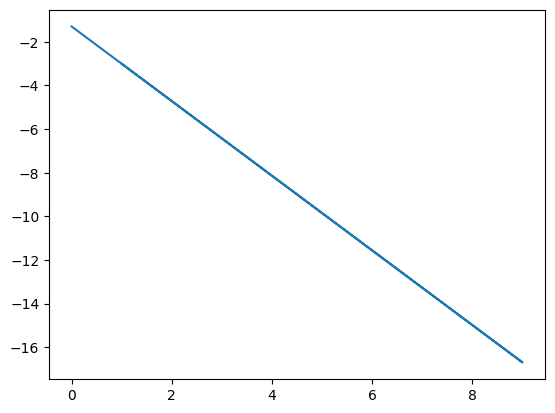

Direction is: 300.29578527616076
Sorted vector of angles: [18.913872913036105, 182.02136494035602, 300.29578527616076]
Getting intersections in skeleton (more than 2 neighbours)
0 intersections found in the skeleton
Solidity = 0.8319327731092437 -> no intersection in this contour
Descriptors: [[18.913872913036105, 182.02136494035602, 300.29578527616076]] for mapbox image 50.7771172_3.5208395.png
Number of descriptors: 1
Descriptor of segmentation image:
[71.56505117707798, 176.38170223086667, 289.79450363229324]
Descriptor of mapbox image:
[18.913872913036105, 182.02136494035602, 300.29578527616076]
x = 71.56505117707798, y = 18.913872913036105
x = 176.38170223086667, y = 182.02136494035602
x = 289.79450363229324, y = 300.29578527616076
Result = 53.983601993869854
**************************************************
Mapbox image: 50.7769226_3.5283001.png
**************************************************
Finding descriptors in mapbox image 50.7769226_3.5283001.png
Getting intersections i

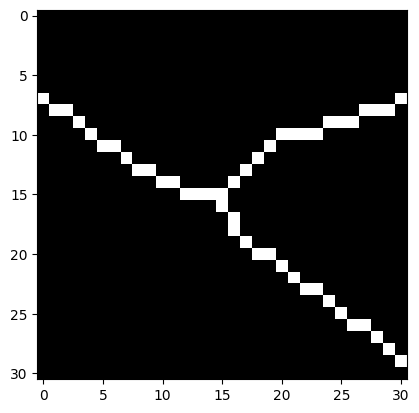

Road pixels for neighbour pixel (14, 15) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.   0.]
 [ -3.   0.]
 [ -4.   1.]
 [ -5.   1.]
 [ -6.   2.]
 [ -7.   2.]
 [ -8.   3.]
 [ -9.   4.]
 [-10.   4.]
 [-11.   5.]
 [-12.   6.]
 [-13.   7.]
 [-14.   7.]
 [-15.   8.]
 [ -1.   0.]
 [  0.   0.]]
Line: [-0.57647059 -1.19852941]


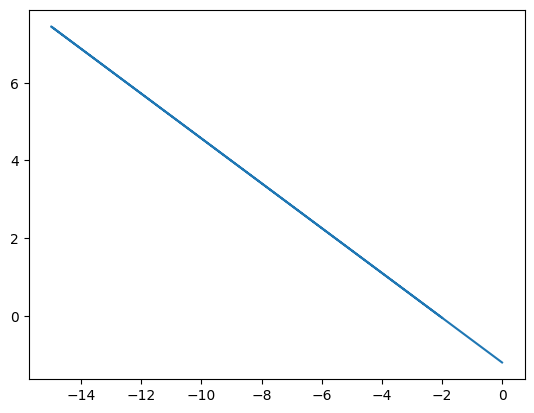

Direction is: 150.03781590358224
Road pixels for neighbour pixel (15, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  1.  -2.]
 [  1.  -3.]
 [  2.  -4.]
 [  3.  -5.]
 [  4.  -5.]
 [  5.  -6.]
 [  6.  -7.]
 [  7.  -8.]
 [  8.  -8.]
 [  9.  -9.]
 [ 10. -10.]
 [ 11. -11.]
 [ 12. -11.]
 [ 13. -12.]
 [ 14. -13.]
 [ 15. -14.]
 [  0.  -1.]
 [  0.   0.]]
Line: [-0.82980382 -1.58854099]


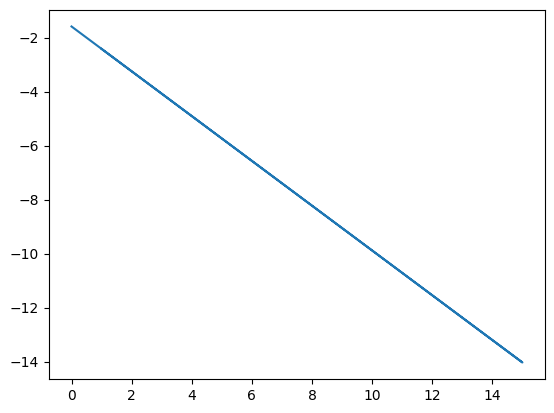

Direction is: 320.3139828909458
Road pixels for neighbour pixel (16, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2.  2.]
 [ 3.  3.]
 [ 4.  4.]
 [ 5.  5.]
 [ 6.  5.]
 [ 7.  5.]
 [ 8.  5.]
 [ 9.  6.]
 [10.  6.]
 [11.  6.]
 [12.  7.]
 [13.  7.]
 [14.  7.]
 [15.  8.]
 [ 1.  1.]
 [ 0.  0.]]
Line: [0.45735294 1.38235294]


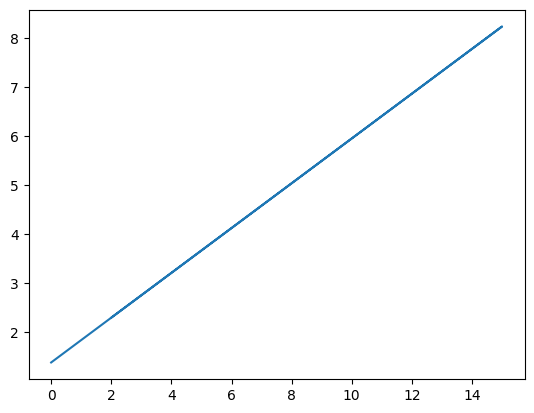

Direction is: 24.577126800677846
Sorted vector of angles: [24.577126800677846, 150.03781590358224, 320.3139828909458]
Descriptors: [[24.577126800677846, 150.03781590358224, 320.3139828909458]] for mapbox image 50.7769226_3.5283001.png
Number of descriptors: 1
Descriptor of segmentation image:
[71.56505117707798, 176.38170223086667, 289.79450363229324]
Descriptor of mapbox image:
[24.577126800677846, 150.03781590358224, 320.3139828909458]
x = 71.56505117707798, y = 24.577126800677846
x = 176.38170223086667, y = 150.03781590358224
x = 289.79450363229324, y = 320.3139828909458
Result = 61.91368183403814
**************************************************
Mapbox image: 50.7760512_3.5240092.png
**************************************************
Finding descriptors in mapbox image 50.7760512_3.5240092.png
Getting intersections in skeleton (more than 2 neighbours)
3 intersections found in the skeleton
Solidity = 0.13876252397471317 -> this contour can be related to an intersection in the road


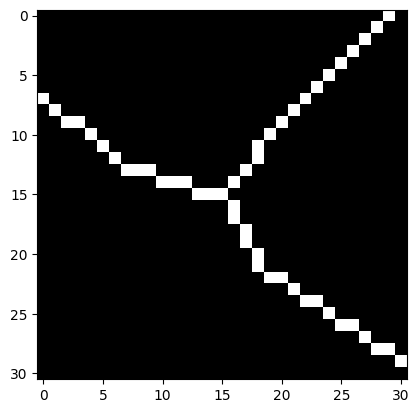

Road pixels for neighbour pixel (14, 15) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.   0.]
 [ -3.   1.]
 [ -4.   1.]
 [ -5.   1.]
 [ -6.   2.]
 [ -7.   2.]
 [ -8.   2.]
 [ -9.   3.]
 [-10.   4.]
 [-11.   5.]
 [-12.   6.]
 [-13.   6.]
 [-14.   7.]
 [-15.   8.]
 [ -1.   0.]
 [  0.   0.]]
Line: [-0.54117647 -1.05882353]


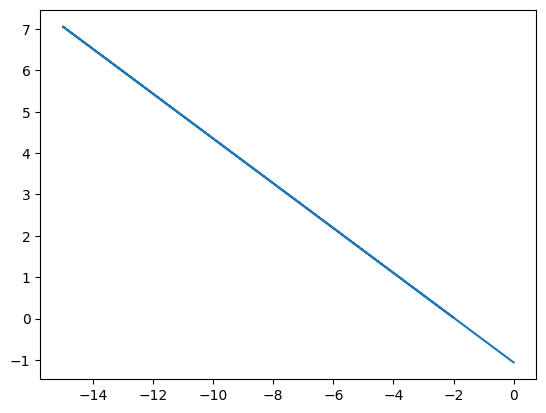

Direction is: 151.57879077547315
Road pixels for neighbour pixel (16, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2.  2.]
 [ 3.  3.]
 [ 3.  4.]
 [ 4.  5.]
 [ 5.  6.]
 [ 6.  7.]
 [ 7.  8.]
 [ 8.  9.]
 [ 9. 10.]
 [10. 11.]
 [11. 12.]
 [12. 13.]
 [13. 14.]
 [14. 15.]
 [ 1.  1.]
 [ 0.  0.]]
Line: [1.07118644 0.26949153]


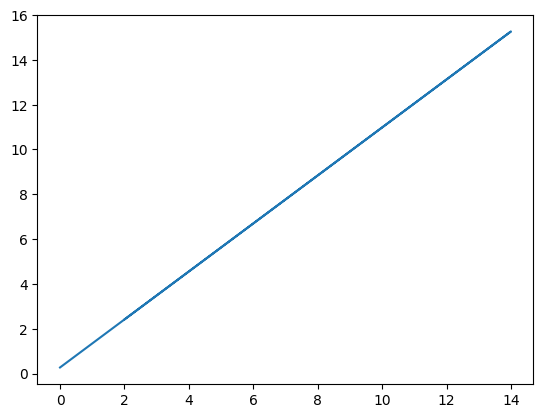

Direction is: 46.968474509273136
Road pixels for neighbour pixel (16, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  1.  -2.]
 [  2.  -3.]
 [  2.  -4.]
 [  3.  -5.]
 [  3.  -6.]
 [  4.  -7.]
 [  5.  -7.]
 [  6.  -8.]
 [  7.  -9.]
 [  8.  -9.]
 [  9. -10.]
 [ 10. -11.]
 [ 11. -11.]
 [ 12. -12.]
 [ 13. -13.]
 [ 14. -13.]
 [ 15. -14.]
 [  1.  -1.]
 [  0.   0.]]
Line: [-0.86138365 -1.91924528]


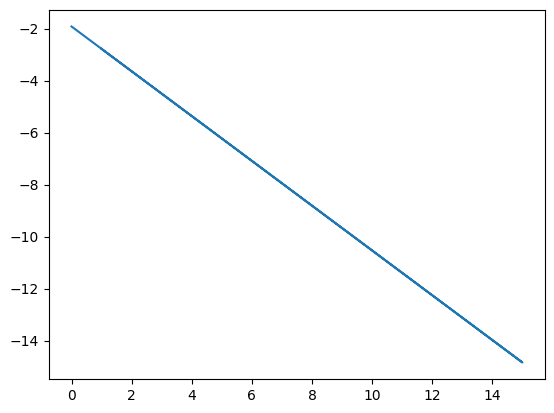

Direction is: 319.25892804783626
Sorted vector of angles: [46.968474509273136, 151.57879077547315, 319.25892804783626]


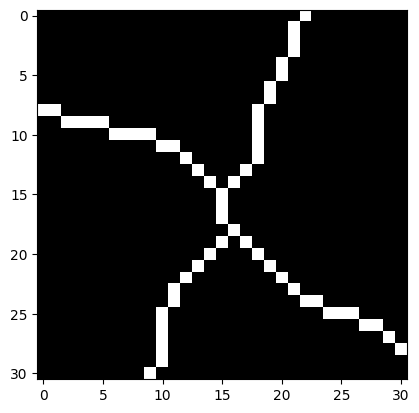

Road pixels for neighbour pixel (14, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.   2.]
 [ -3.   3.]
 [ -4.   4.]
 [ -5.   4.]
 [ -6.   5.]
 [ -7.   5.]
 [ -8.   5.]
 [ -9.   5.]
 [-10.   6.]
 [-11.   6.]
 [-12.   6.]
 [-13.   6.]
 [-14.   7.]
 [-15.   7.]
 [ -1.   1.]
 [  0.   0.]]
Line: [-0.40882353  1.43382353]


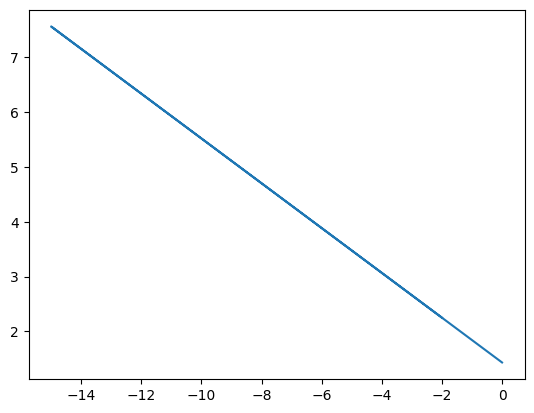

Direction is: 157.76410102003214
Road pixels for neighbour pixel (15, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  0.  -2.]
 [  1.  -3.]
 [  0.  -4.]
 [ -1.  -5.]
 [ -2.  -6.]
 [ -3.  -7.]
 [ -4.  -8.]
 [ -4.  -9.]
 [ -5. -10.]
 [ -5. -11.]
 [ -5. -12.]
 [ -5. -13.]
 [ -5. -14.]
 [ -6. -15.]
 [  2.  -4.]
 [  3.  -5.]
 [  4.  -6.]
 [  5.  -7.]
 [  6.  -8.]
 [  7.  -9.]
 [  8.  -9.]
 [  9. -10.]
 [ 10. -10.]
 [ 11. -10.]
 [ 12. -11.]
 [ 13. -11.]
 [ 14. -12.]
 [ 15. -13.]
 [  0.  -1.]
 [  0.   0.]]
Line: [-0.07741167 -7.97313749]


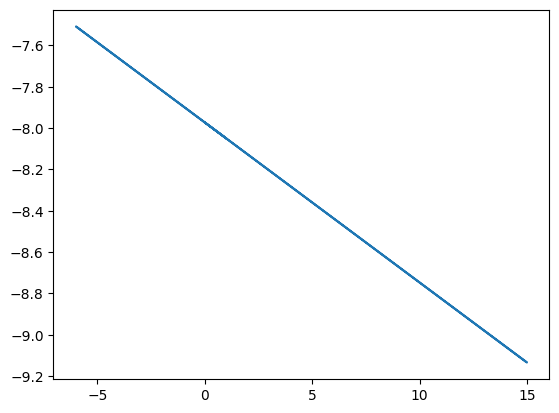

Direction is: 355.57346596428926
Road pixels for neighbour pixel (16, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2.  2.]
 [ 3.  3.]
 [ 3.  4.]
 [ 3.  5.]
 [ 3.  6.]
 [ 3.  7.]
 [ 4.  8.]
 [ 4.  9.]
 [ 5. 10.]
 [ 5. 11.]
 [ 6. 12.]
 [ 6. 13.]
 [ 6. 14.]
 [ 7. 15.]
 [ 1.  1.]
 [ 0.  0.]]
Line: [ 2.38316722 -1.58582503]


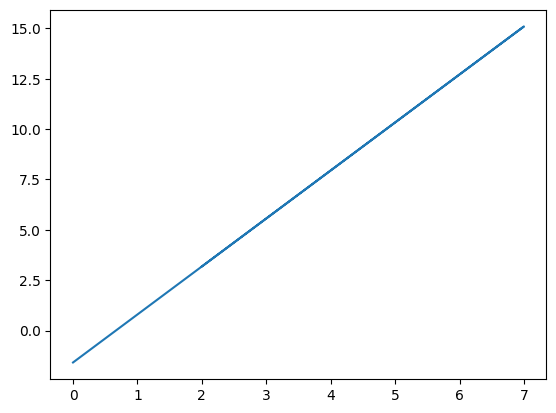

Direction is: 67.23660790423946
Sorted vector of angles: [67.23660790423946, 157.76410102003214, 355.57346596428926]


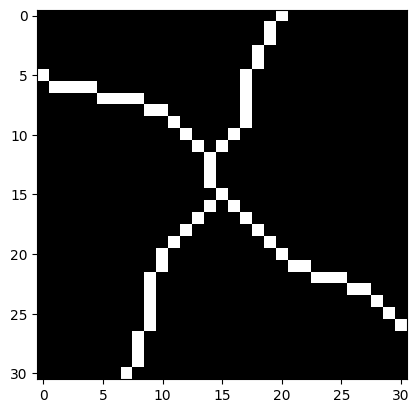

Road pixels for neighbour pixel (14, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -1.   2.]
 [ -1.   3.]
 [ -2.   4.]
 [ -3.   5.]
 [ -4.   6.]
 [ -5.   7.]
 [ -6.   7.]
 [ -7.   8.]
 [ -8.   8.]
 [ -9.   8.]
 [-10.   8.]
 [-11.   9.]
 [-12.   9.]
 [-13.   9.]
 [-14.   9.]
 [-15.  10.]
 [  0.   4.]
 [  1.   5.]
 [  2.   6.]
 [  2.   7.]
 [  2.   8.]
 [  2.   9.]
 [  2.  10.]
 [  3.  11.]
 [  3.  12.]
 [  4.  13.]
 [  4.  14.]
 [  5.  15.]
 [ -1.   1.]
 [  0.   0.]]
Line: [0.02948605 7.65709054]


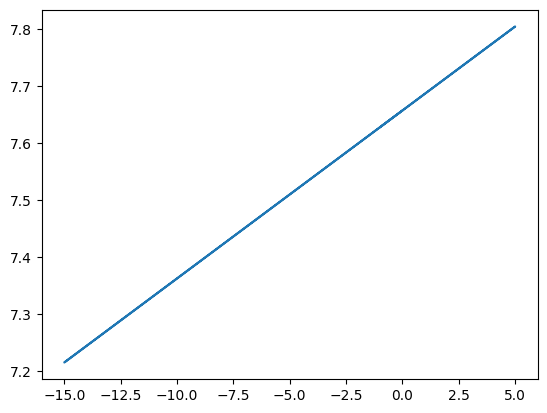

Direction is: 181.6889366472503
Road pixels for neighbour pixel (14, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.  -2.]
 [ -3.  -3.]
 [ -4.  -4.]
 [ -5.  -5.]
 [ -5.  -6.]
 [ -6.  -7.]
 [ -6.  -8.]
 [ -6.  -9.]
 [ -6. -10.]
 [ -6. -11.]
 [ -7. -12.]
 [ -7. -13.]
 [ -7. -14.]
 [ -8. -15.]
 [ -1.  -1.]
 [  0.   0.]]
Line: [1.92123552 1.98610039]


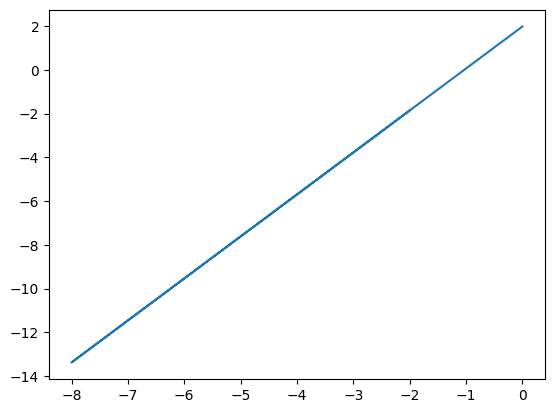

Direction is: 242.5030951773691
Road pixels for neighbour pixel (16, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  2.  -2.]
 [  3.  -3.]
 [  4.  -4.]
 [  5.  -5.]
 [  6.  -6.]
 [  7.  -6.]
 [  8.  -7.]
 [  9.  -7.]
 [ 10.  -7.]
 [ 11.  -8.]
 [ 12.  -8.]
 [ 13.  -9.]
 [ 14. -10.]
 [ 15. -11.]
 [  1.  -1.]
 [  0.   0.]]
Line: [-0.65588235 -0.95588235]


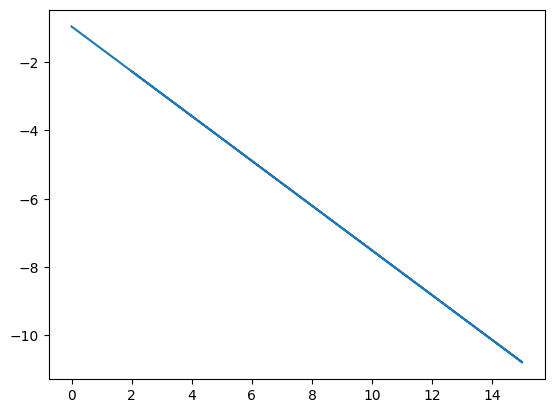

Direction is: 326.739838167771
Sorted vector of angles: [181.6889366472503, 242.5030951773691, 326.739838167771]
Descriptors: [[46.968474509273136, 151.57879077547315, 319.25892804783626], [67.23660790423946, 157.76410102003214, 355.57346596428926], [181.6889366472503, 242.5030951773691, 326.739838167771]] for mapbox image 50.7760512_3.5240092.png
Number of descriptors: 3
Descriptor of segmentation image:
[71.56505117707798, 176.38170223086667, 289.79450363229324]
Descriptor of mapbox image:
[46.968474509273136, 151.57879077547315, 319.25892804783626]
x = 71.56505117707798, y = 46.968474509273136
x = 176.38170223086667, y = 151.57879077547315
x = 289.79450363229324, y = 319.25892804783626
Result = 45.69823089112466
Descriptor of mapbox image:
[67.23660790423946, 157.76410102003214, 355.57346596428926]
x = 71.56505117707798, y = 67.23660790423946
x = 176.38170223086667, y = 157.76410102003214
x = 289.79450363229324, y = 355.57346596428926
Result = 68.49979840471063
Descriptor of mapbox 

In [50]:
best_mb_image = None
lowest_score = 1000

for mb_image in os.listdir(mapbox_imgs_dir_path) : 
    score = 0
    mb_image_path = os.path.join(mapbox_imgs_dir_path, mb_image)
    print(50*"*")
    print(f"Mapbox image: {mb_image}")
    print(50*"*")
    mb_image_bgr = cv2.imread(mb_image_path)
    des = find_descriptors_in_mapbox_image(mb_image_path, mb_image)
    print(f"Descriptors: {des} for mapbox image {mb_image}")

    # matching process
    if des is not None and segm_img_des is not None :
        print(f"Number of descriptors: {len(des)}")
        for des_segm in segm_img_des :
            best_result_per_des = 1000 # best descriptor match for descriptor des_segm of segmentation image
            print(f"Descriptor of segmentation image:")
            print(des_segm)
            for des_ in des :
                print(f"Descriptor of mapbox image:")
                print(des_)

                if len(des_segm) == len(des_) : 
                    result = 0
                    for x, y in zip(des_segm, des_) :
                        print(f"x = {x}, y = {y}")
                        result += (x-y)**2
                    result = math.sqrt(result)
                elif len(des_) > len(des_segm) :
                    for x in des_segm : 
                        best_diff = 1000
                        for y in des_ :
                            diff = abs(x-y)
                            if diff < best_diff :
                                best_diff = diff
                        result += best_diff**2
                    result = math.sqrt(result)
                else :
                    # this can't be the case 
                    continue

                print(f"Result = {result}")
            
                if result < best_result_per_des :
                    best_result_per_des = result
            
            score += best_result_per_des
        
        if score < lowest_score :
            lowest_score = score
            best_mb_image = mb_image
    else:
        continue

print(f"Lowest score = {lowest_score} with mapbox image {best_mb_image}")